# Práctica 4: Anemometría Láser Doppler (LDA) - Perfil de Velocidades

## Objetivo
Medir perfiles de velocidad en un túnel de viento utilizando técnica láser Doppler (LDA/LDV), una técnica óptica no intrusiva que permite obtener mediciones puntuales de velocidad con alta precisión.

## Fundamento Teórico

### ¿Qué es LDA?
La **Anemometría Láser Doppler** se basa en el efecto Doppler de la luz dispersada por partículas trazadoras que se mueven con el fluido. Dos haces láser coherentes se cruzan formando un **volumen de medida** donde se genera un patrón de franjas de interferencia.

Cuando una partícula atraviesa este volumen:
- Dispersa luz con una frecuencia modulada proporcional a su velocidad
- La frecuencia Doppler $f_D$ está relacionada con la velocidad por: 
$$V = \frac{\lambda \cdot f_D}{2 \sin(\theta/2)}$$
donde $\lambda$ es la longitud de onda del láser y $\theta$ el ángulo entre haces.

### Ventajas de LDA
- ✅ **No intrusiva**: no perturba el flujo
- ✅ **Alta resolución espacial y temporal**
- ✅ **Medición directa de velocidad** (no requiere calibración)
- ✅ **Puede medir flujos inversos** y turbulencia

### Datos LDA típicos
Cada medición registra:
1. **Tiempo de llegada** (ms)
2. **Velocidad** (m/s o componente U, V)
3. **SNR** (Signal-to-Noise Ratio) - calidad de señal
4. **Validación** - indicadores de calidad

---

## Estructura de los Datos

En `files/P4/` tenemos 4 carpetas (FX01G00 a FX04G00), cada una representa una **posición Y diferente** en el perfil del túnel.

Dentro de cada carpeta hay ~15 archivos `.txt`, cada uno con ~2000 mediciones de velocidad en esa posición.

Nuestro objetivo: **construir el perfil U(y)** promediando todas las mediciones por posición.

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from scipy.fft import fft, fftfreq
import warnings
import os 

warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ Librerías cargadas correctamente (incluyendo os)")

✅ Librerías cargadas correctamente (incluyendo os)


## 1. Configuración de Rutas y Exploración de Datos

Primero localizamos los datos en `files/P4/` y exploramos la estructura.

In [2]:
# Configuración de rutas
BASE_DIR = Path.cwd().parent.parent.parent
DATA_DIR = BASE_DIR / 'files' / 'P4'
IMAGES_DIR = BASE_DIR / 'Practicas' / 'P04_LDA_Perfil_Velocidad' / 'data' / 'images'
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

print(f"📂 Directorio base: {BASE_DIR}")
print(f"📂 Directorio de datos: {DATA_DIR}")
print(f"✅ Datos existen: {DATA_DIR.exists()}")

# Listar las carpetas (cada una es una posición Y)
folders = sorted([f for f in DATA_DIR.iterdir() if f.is_dir()])
print(f"\n📁 Carpetas encontradas ({len(folders)}):")
for folder in folders:
    files_count = len(list(folder.glob('*.txt')))
    print(f"  - {folder.name}: {files_count} archivos")

📂 Directorio base: c:\Users\edgar\Documents\GitHub\Aero-Messure
📂 Directorio de datos: c:\Users\edgar\Documents\GitHub\Aero-Messure\files\P4
✅ Datos existen: True

📁 Carpetas encontradas (4):
  - FX01G00: 15 archivos
  - FX02G00: 15 archivos
  - FX03G00: 15 archivos
  - FX04G00: 15 archivos


## 2. Lectura y Análisis de un Archivo Individual

Examinemos un archivo para entender el formato de datos.

In [3]:
# Leer un archivo de ejemplo
sample_file = folders[0] / list(folders[0].glob('*.txt'))[0]
print(f"📄 Archivo de ejemplo: {sample_file.name}")

df_sample = pd.read_csv(sample_file, sep=r'\s+', header=None,
                        names=['idx', 'Doppler_Freq', 'SNR', 'U', 'V'])
# ------------------------------------------------

print(f"\n📊 Forma de datos: {df_sample.shape}")
print(f"   → {df_sample.shape[0]} mediciones × {df_sample.shape[1]} columnas")

print("\n🔍 Primeras 10 filas:")
print(df_sample.head(10))

print("\n📈 Estadísticas descriptivas:")
print(df_sample.describe())
# -------------------------------------------------------------

📄 Archivo de ejemplo: L01G00_001.txt

📊 Forma de datos: (2000, 5)
   → 2000 mediciones × 5 columnas

🔍 Primeras 10 filas:
   idx  Doppler_Freq    SNR     U     V
0    1        18.770  311.8  0.44 -0.00
1    2        20.326  245.8  0.45 -0.00
2    3        20.873  293.5  0.43 -0.00
3    4        24.969  282.2  0.41 -0.00
4    5        25.651  234.4  0.22  0.00
5    6        25.979  355.0  0.22 -0.00
6    7        31.031  359.5  0.44 -0.00
7    8        31.331  250.3  0.26 -0.00
8    9        31.495  136.5  0.26 -0.01
9   10        31.904  355.0  0.25 -0.01

📈 Estadísticas descriptivas:
               idx  Doppler_Freq          SNR            U            V
count  2000.000000   2000.000000  2000.000000  2000.000000  2000.000000
mean   1000.500000   1869.129679   399.047250     0.377125     0.001160
std     577.494589   1068.508341   226.256351     0.076059     0.008215
min       1.000000     18.770000    45.500000     0.170000    -0.050000
25%     500.750000    950.207500   245.800000   

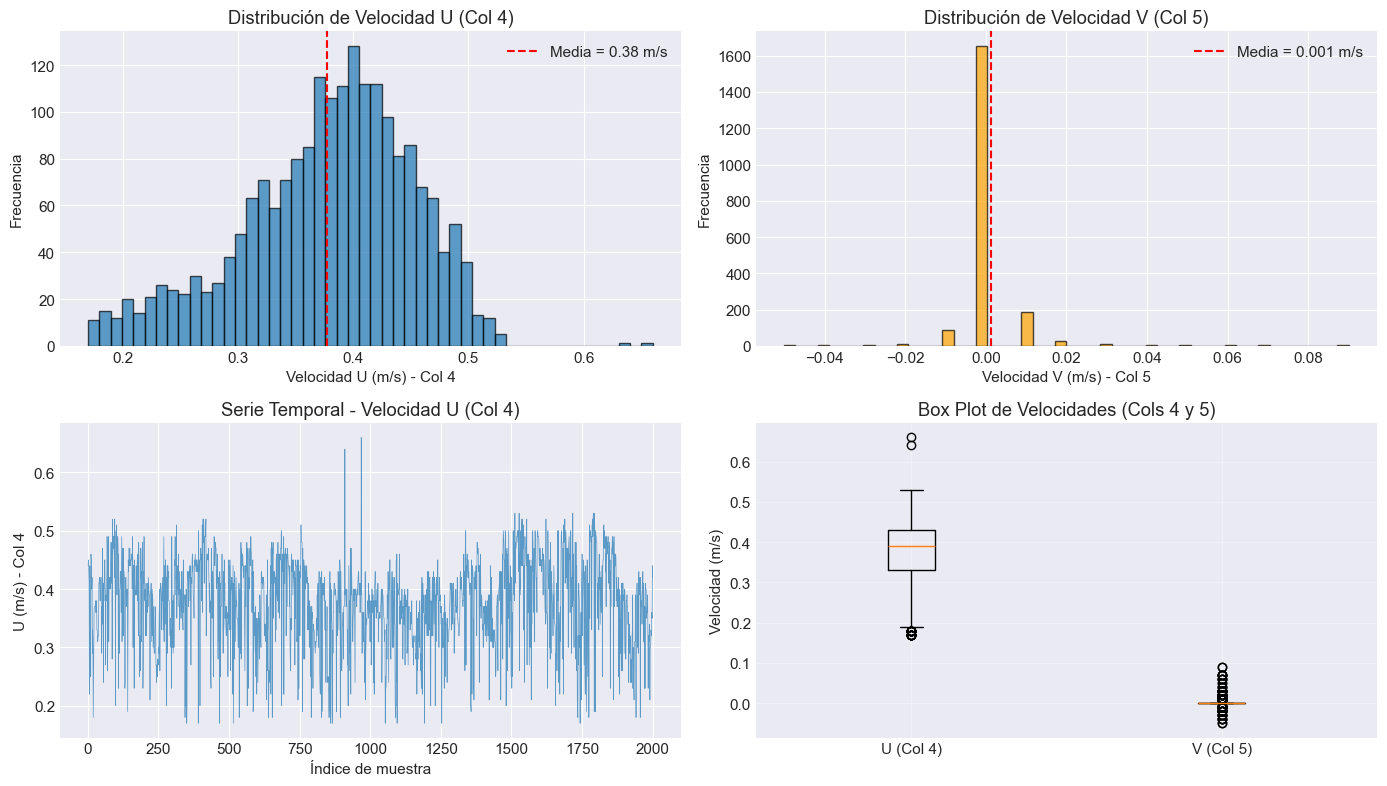


📊 Análisis del archivo L01G00_001.txt (usando Col 4 como U, Col 5 como V):
   U media: 0.377 m/s
   U std:   0.076 m/s
   V media: 0.001 m/s (transversal)
   V std:   0.008 m/s


In [4]:
# Visualización de datos brutos de un archivo
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
# ---------------------------------------------------------------------

# Velocidad U (Columna 4)
axes[0, 0].hist(df_sample['U'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Velocidad U (m/s) - Col 4') # Etiqueta actualizada
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Velocidad U (Col 4)') # Título actualizado
axes[0, 0].axvline(df_sample['U'].mean(), color='r', linestyle='--',
                    label=f'Media = {df_sample["U"].mean():.2f} m/s')
axes[0, 0].legend()

# Velocidad V (Columna 5)
axes[0, 1].hist(df_sample['V'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Velocidad V (m/s) - Col 5') # Etiqueta actualizada
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Velocidad V (Col 5)') # Título actualizado
axes[0, 1].axvline(df_sample['V'].mean(), color='r', linestyle='--',
                    label=f'Media = {df_sample["V"].mean():.3f} m/s')
axes[0, 1].legend()

# Serie temporal U (Columna 4)
axes[1, 0].plot(df_sample['idx'], df_sample['U'], linewidth=0.5, alpha=0.7)
axes[1, 0].set_xlabel('Índice de muestra')
axes[1, 0].set_ylabel('U (m/s) - Col 4') # Etiqueta actualizada
axes[1, 0].set_title('Serie Temporal - Velocidad U (Col 4)') # Título actualizado

# Box plot (Columnas 4 y 5)
axes[1, 1].boxplot([df_sample['U'], df_sample['V']], labels=['U (Col 4)', 'V (Col 5)']) # Etiquetas actualizadas
axes[1, 1].set_ylabel('Velocidad (m/s)')
axes[1, 1].set_title('Box Plot de Velocidades (Cols 4 y 5)') # Título actualizado
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'box_plot_de_velocidades_cols_4_y_5.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(IMAGES_DIR, 'box_plot_de_velocidades_cols_4_y_5.svg'), bbox_inches='tight')
plt.show()

print(f"\n📊 Análisis del archivo {sample_file.name} (usando Col 4 como U, Col 5 como V):")
print(f"   U media: {df_sample['U'].mean():.3f} m/s")
print(f"   U std:   {df_sample['U'].std():.3f} m/s")
print(f"   V media: {df_sample['V'].mean():.3f} m/s (transversal)")
print(f"   V std:   {df_sample['V'].std():.3f} m/s")
# -----------------------------------------------------------------------------------

## 3. Función para Procesar Todos los Archivos de una Posición

Crearemos una función que:
1. Lee todos los archivos de una carpeta (posición Y)
2. Filtra outliers usando criterio IQR (Rango Intercuartílico)
3. Calcula estadísticos robustos (media, std, error estándar)

**Método de detección de outliers:**
- Calculamos Q1 (percentil 25) y Q3 (percentil 75)
- IQR = Q3 - Q1
- Outliers: valores fuera de [Q1 - 1.5×IQR, Q3 + 1.5×IQR]

In [5]:
def remove_outliers_iqr(data, factor=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    mask = (data >= lower_bound) & (data <= upper_bound)
    return data[mask], mask


def process_position_folder(folder_path, remove_outliers=True):
    all_U = []
    all_V = []

    # Leer todos los archivos .txt de la carpeta
    txt_files = list(folder_path.glob('*.txt'))

    for file in txt_files:
        df = pd.read_csv(file, sep=r'\s+', header=None,
                        names=['idx', 'Doppler_Freq', 'SNR', 'U', 'V'])
        all_U.extend(df['U'].values)
        all_V.extend(df['V'].values)

    all_U = np.array(all_U)
    all_V = np.array(all_V)

    if remove_outliers:
        U_clean, mask_U = remove_outliers_iqr(all_U)
        V_clean, mask_V = remove_outliers_iqr(all_V)
        outliers_removed_U = len(all_U) - len(U_clean)
        outliers_removed_V = len(all_V) - len(V_clean)
    else:
        U_clean = all_U
        V_clean = all_V
        outliers_removed_U = 0
        outliers_removed_V = 0

    # Calcular estadísticos
    results = {
        'folder': folder_path.name,
        'n_files': len(txt_files),
        'n_samples_total': len(all_U),
        'n_samples_clean_U': len(U_clean),
        'n_samples_clean_V': len(V_clean),
        'outliers_removed_U': outliers_removed_U,
        'outliers_removed_V': outliers_removed_V,
        'U_mean': np.mean(U_clean),
        'U_std': np.std(U_clean),
        'U_stderr': stats.sem(U_clean),  # Error estándar de la media
        'V_mean': np.mean(V_clean),
        'V_std': np.std(V_clean),
        'V_stderr': stats.sem(V_clean),
        # Guardamos los datos limpios para análisis posteriores si es necesario
        # 'U_all': all_U,
        # 'V_all': all_V,
        'U_clean': U_clean,
        'V_clean': V_clean
    }

    return results

print("✅ Funciones de procesamiento definidas ")

✅ Funciones de procesamiento definidas 


## 4. Procesar Todas las Posiciones

Ahora procesamos las 4 carpetas (posiciones Y) y almacenamos los resultados.

In [6]:
# Procesar todas las carpetas
results_all = []

print("🔄 Procesando posiciones...")
print("="*70)

for folder in folders:
    print(f"\n📁 Procesando: {folder.name}")
    result = process_position_folder(folder, remove_outliers=True)
    results_all.append(result)
    
    print(f"   Archivos: {result['n_files']}")
    print(f"   Muestras totales: {result['n_samples_total']}")
    print(f"   Outliers eliminados (U): {result['outliers_removed_U']} "
          f"({100*result['outliers_removed_U']/result['n_samples_total']:.1f}%)")
    print(f"   U = {result['U_mean']:.3f} ± {result['U_std']:.3f} m/s")
    print(f"   V = {result['V_mean']:.4f} ± {result['V_std']:.4f} m/s")

print("\n" + "="*70)
print("✅ Procesamiento completado")

🔄 Procesando posiciones...

📁 Procesando: FX01G00
   Archivos: 15
   Muestras totales: 30000
   Outliers eliminados (U): 950 (3.2%)
   U = 0.516 ± 0.060 m/s
   V = 0.0138 ± 0.0212 m/s

📁 Procesando: FX02G00
   Archivos: 15
   Muestras totales: 29138
   Outliers eliminados (U): 960 (3.3%)
   U = 1.026 ± 0.092 m/s
   V = 0.0201 ± 0.0389 m/s

📁 Procesando: FX03G00
   Archivos: 15
   Muestras totales: 30000
   Outliers eliminados (U): 1702 (5.7%)
   U = 2.000 ± 0.162 m/s
   V = 0.0678 ± 0.1022 m/s

📁 Procesando: FX04G00
   Archivos: 15
   Muestras totales: 30000
   Outliers eliminados (U): 1703 (5.7%)
   U = 2.984 ± 0.249 m/s
   V = 0.0655 ± 0.1260 m/s

✅ Procesamiento completado


## 5. Construcción del Perfil de Velocidades U(y)

Para graficar el perfil necesitamos asignar posiciones Y a cada carpeta. 

**Asumimos** que las carpetas están ordenadas de abajo hacia arriba (o viceversa) en el túnel. Si conoces las posiciones reales en mm, ajusta el array `y_positions`.

In [7]:
# Posiciones Y: ajusta estos valores según tus mediciones reales
y_positions = np.array([10, 30, 50, 70])  # mm, ejemplo

# Extraer datos para el perfil
U_means = np.array([r['U_mean'] for r in results_all])
U_stderrs = np.array([r['U_stderr'] for r in results_all])

# Crear DataFrame resumen
df_profile = pd.DataFrame({
    'Posición': [r['folder'] for r in results_all],
    'y (mm)': y_positions,
    'U_mean (m/s)': U_means,
    'U_std (m/s)': [r['U_std'] for r in results_all],
    'U_stderr (m/s)': U_stderrs,
    'V_mean (m/s)': [r['V_mean'] for r in results_all],
    'N_muestras': [r['n_samples_clean_U'] for r in results_all]
})

print("📊 Tabla Resumen del Perfil de Velocidades:")
print("="*80)
print(df_profile.to_string(index=False))
print("="*80)

📊 Tabla Resumen del Perfil de Velocidades:
Posición  y (mm)  U_mean (m/s)  U_std (m/s)  U_stderr (m/s)  V_mean (m/s)  N_muestras
 FX01G00      10      0.516136     0.060306        0.000354      0.013827       29050
 FX02G00      30      1.025656     0.091684        0.000546      0.020127       28178
 FX03G00      50      1.999545     0.161548        0.000960      0.067807       28298
 FX04G00      70      2.984378     0.249218        0.001482      0.065534       28297


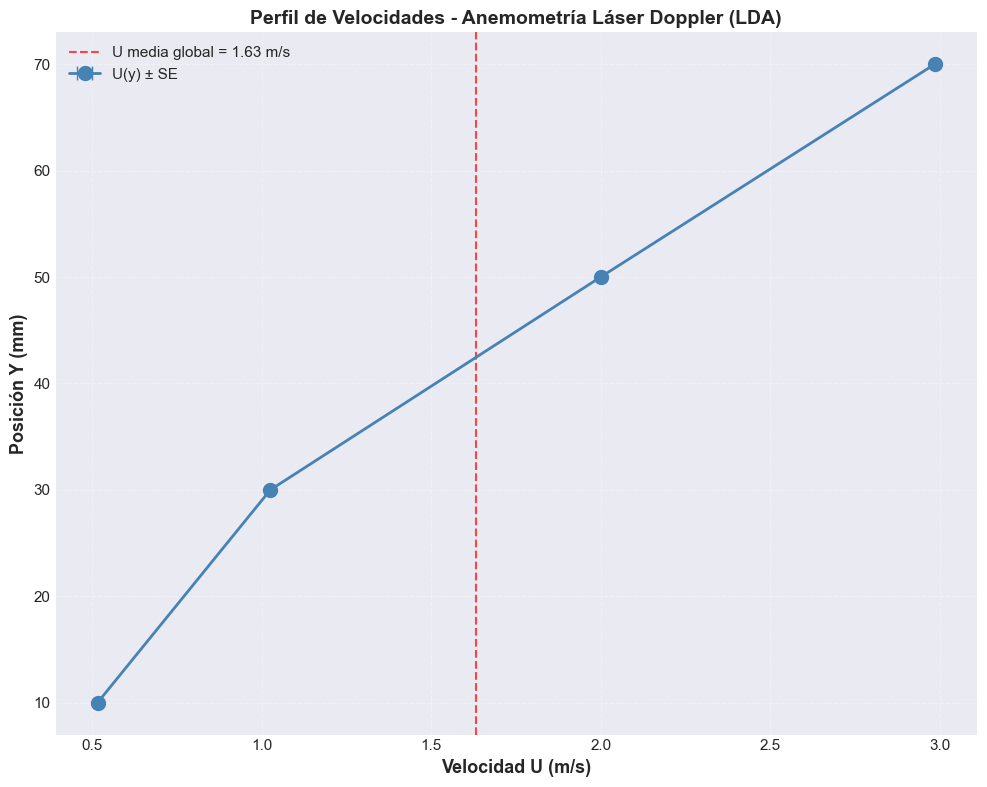


📈 Velocidad media del perfil: 1.631 m/s
   Rango de velocidades: 0.516 - 2.984 m/s
   Variación: 2.468 m/s


In [8]:
# Gráfico del perfil de velocidades U(y)
fig, ax = plt.subplots(figsize=(10, 8))

# Perfil con barras de error (error estándar)
ax.errorbar(U_means, y_positions, xerr=U_stderrs, 
            fmt='o-', markersize=10, linewidth=2, capsize=5,
            label='U(y) ± SE', color='steelblue', elinewidth=2)

# Línea de referencia de velocidad media global
U_global_mean = U_means.mean()
ax.axvline(U_global_mean, color='red', linestyle='--', linewidth=1.5,
           label=f'U media global = {U_global_mean:.2f} m/s', alpha=0.7)

ax.set_xlabel('Velocidad U (m/s)', fontsize=13, fontweight='bold')
ax.set_ylabel('Posición Y (mm)', fontsize=13, fontweight='bold')
ax.set_title('Perfil de Velocidades - Anemometría Láser Doppler (LDA)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'perfil_de_velocidades_anemometra_lser_doppler_lda.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(IMAGES_DIR, 'perfil_de_velocidades_anemometra_lser_doppler_lda.svg'), bbox_inches='tight')
plt.show()

print(f"\n📈 Velocidad media del perfil: {U_global_mean:.3f} m/s")
print(f"   Rango de velocidades: {U_means.min():.3f} - {U_means.max():.3f} m/s")
print(f"   Variación: {U_means.max() - U_means.min():.3f} m/s")

## 6. Análisis de Turbulencia

Calculamos la **intensidad de turbulencia** en cada posición:

$$I_u = \frac{\sigma_U}{U_{mean}} \times 100\%$$

Donde:
- $\sigma_U$ es la desviación estándar de U
- $U_{mean}$ es la velocidad media

La intensidad de turbulencia indica qué tan "agitado" está el flujo respecto a su velocidad media.

🌪️  Intensidad de Turbulencia por Posición:
FX01G00      (y= 10.0 mm): I_u = 11.68%
FX02G00      (y= 30.0 mm): I_u =  8.94%
FX03G00      (y= 50.0 mm): I_u =  8.08%
FX04G00      (y= 70.0 mm): I_u =  8.35%


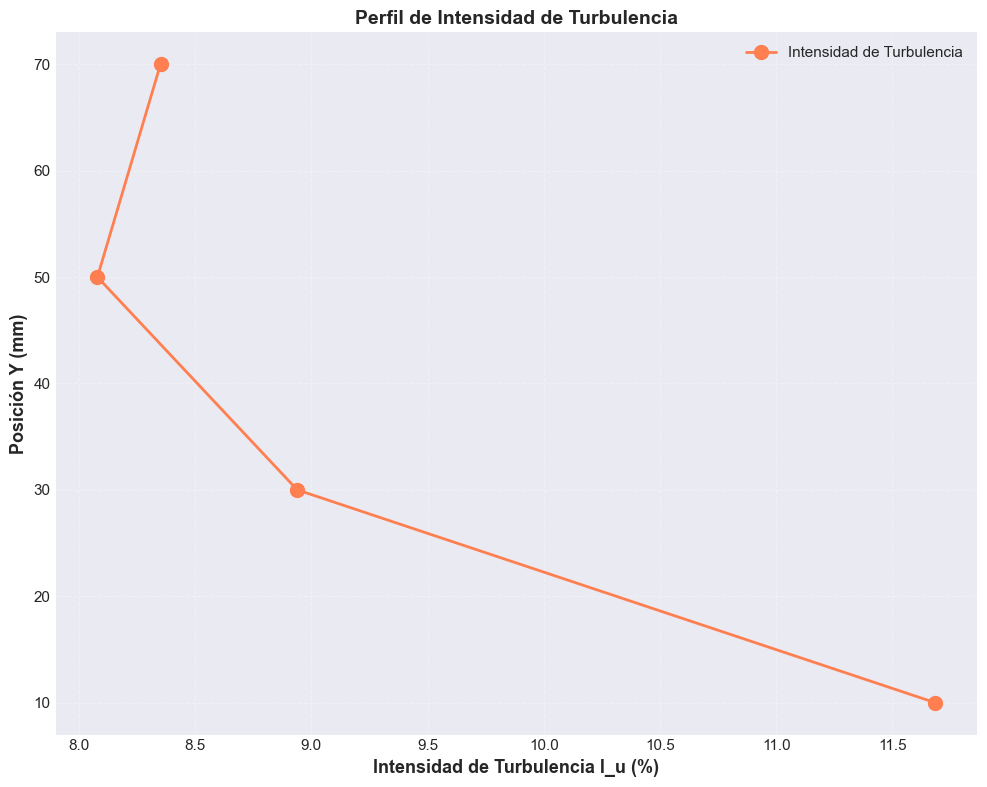

In [9]:
# Calcular intensidad de turbulencia
turbulence_intensity = []

for result in results_all:
    I_u = (result['U_std'] / result['U_mean']) * 100
    turbulence_intensity.append(I_u)

df_profile['Turbulencia (%)'] = turbulence_intensity

print("🌪️  Intensidad de Turbulencia por Posición:")
print("="*60)
for i, row in df_profile.iterrows():
    print(f"{row['Posición']:12s} (y={row['y (mm)']:5.1f} mm): "
          f"I_u = {row['Turbulencia (%)']:5.2f}%")
print("="*60)

# Gráfico de intensidad de turbulencia
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(turbulence_intensity, y_positions, 'o-', markersize=10, 
        linewidth=2, color='coral', label='Intensidad de Turbulencia')

ax.set_xlabel('Intensidad de Turbulencia I_u (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Posición Y (mm)', fontsize=13, fontweight='bold')
ax.set_title('Perfil de Intensidad de Turbulencia', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'perfil_intensidad_turbulencia_lda.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(IMAGES_DIR, 'perfil_intensidad_turbulencia_lda.svg'), bbox_inches='tight')
plt.show()

## 7. Comparación de Distribuciones por Posición

Visualizamos las distribuciones de velocidad U en cada posición para identificar comportamientos.

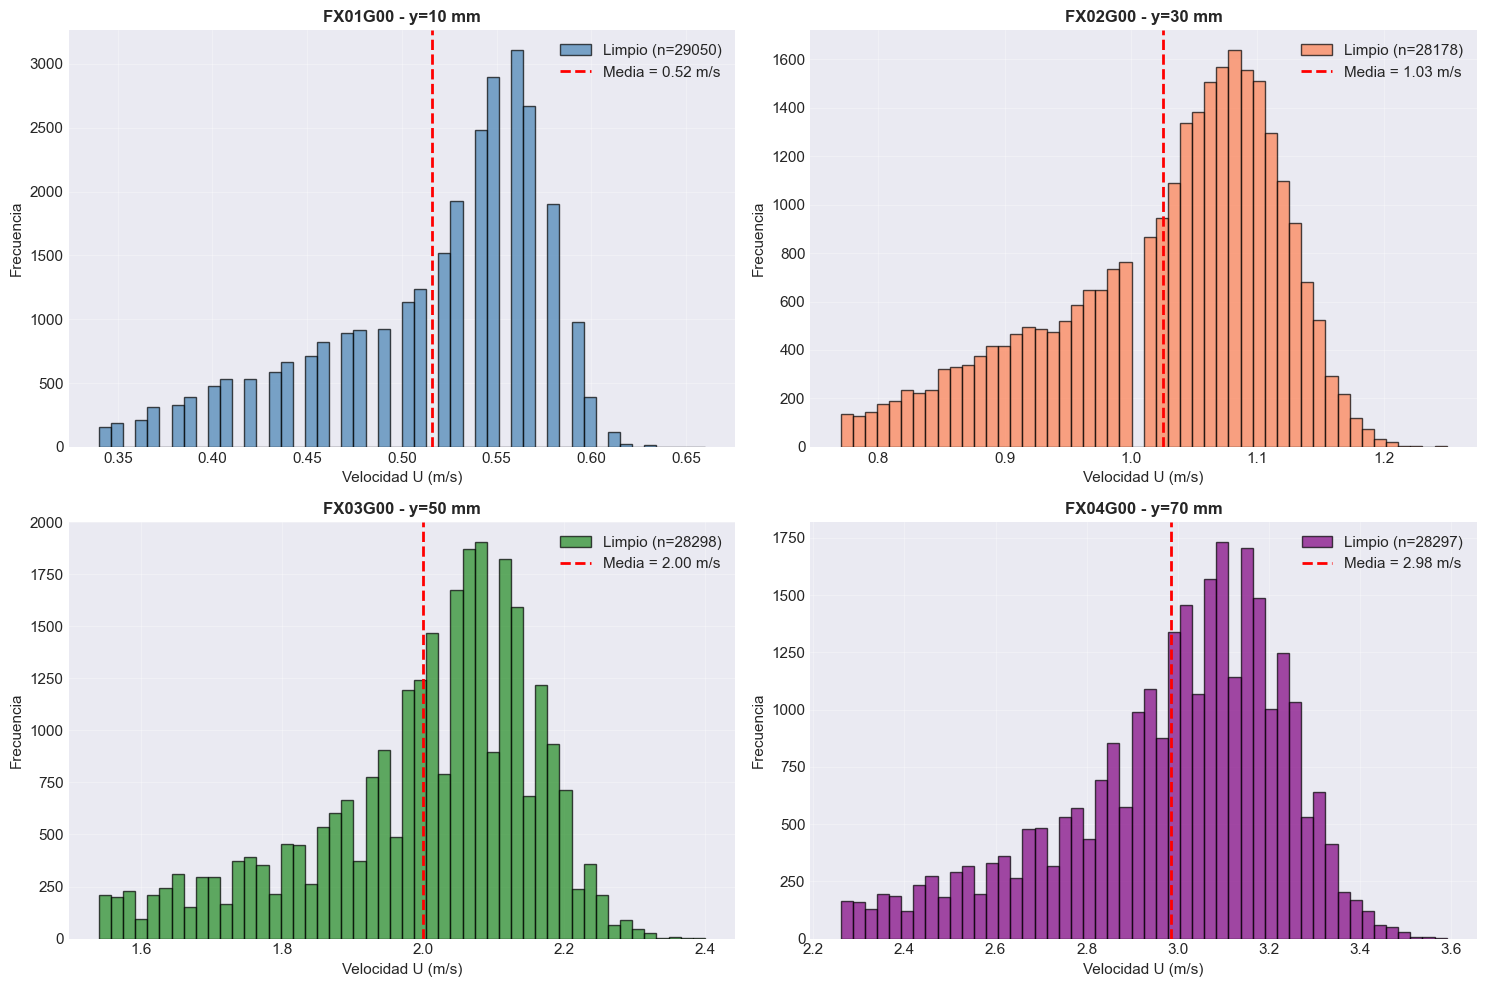

In [10]:
# Histogramas superpuestos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

colors = ['steelblue', 'coral', 'forestgreen', 'purple']

for i, result in enumerate(results_all):
    ax = axes[i]
    
    # Histograma de datos limpios
    ax.hist(result['U_clean'], bins=50, alpha=0.7, color=colors[i], 
            edgecolor='black', label=f"Limpio (n={len(result['U_clean'])})")
    
    # Línea vertical en la media
    ax.axvline(result['U_mean'], color='red', linestyle='--', linewidth=2,
               label=f"Media = {result['U_mean']:.2f} m/s")
    
    ax.set_xlabel('Velocidad U (m/s)', fontsize=11)
    ax.set_ylabel('Frecuencia', fontsize=11)
    ax.set_title(f"{result['folder']} - y={y_positions[i]} mm", 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'histogramas_velocidad_U_limpia.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(IMAGES_DIR, 'histogramas_velocidad_U_limpia.svg'), bbox_inches='tight')
plt.show()

## 8. Análisis de Calidad de Datos

Evaluamos la calidad de las mediciones:
1. **Ratio señal/ruido implícito**: menor dispersión = mejor calidad
2. **Consistencia entre archivos**: comparar varianza inter-archivo vs intra-archivo
3. **Convergencia estadística**: verificar que tenemos suficientes muestras

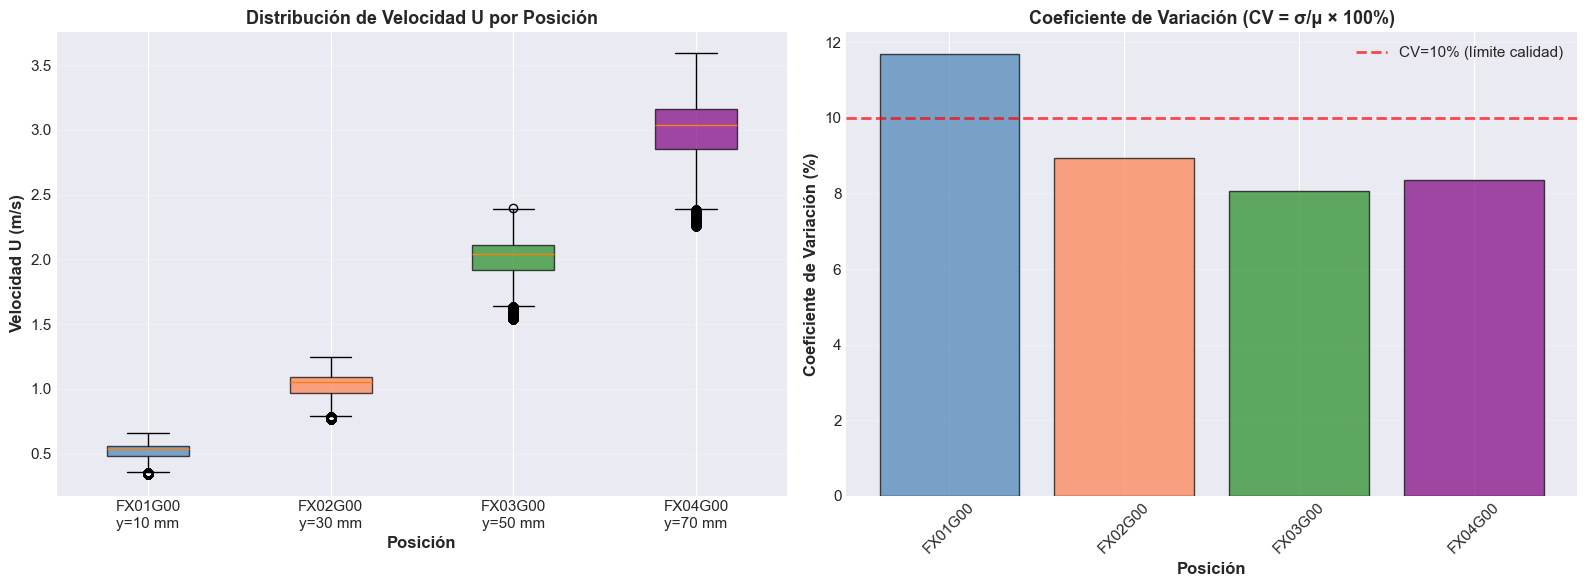


📊 Métricas de Calidad:
FX01G00     : CV=11.68% → Calidad: Regular
FX02G00     : CV= 8.94% → Calidad: Buena
FX03G00     : CV= 8.08% → Calidad: Buena
FX04G00     : CV= 8.35% → Calidad: Buena


In [11]:
# Box plot comparativo de todas las posiciones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot de velocidad U
U_data = [r['U_clean'] for r in results_all]
positions_labels = [f"{r['folder']}\ny={y_positions[i]} mm" 
                   for i, r in enumerate(results_all)]

bp1 = ax1.boxplot(U_data, labels=positions_labels, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('Velocidad U (m/s)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Posición', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Velocidad U por Posición', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Coeficiente de variación (CV) por posición
cv_values = [(r['U_std']/r['U_mean'])*100 for r in results_all]
ax2.bar(range(len(cv_values)), cv_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Posición', fontsize=12, fontweight='bold')
ax2.set_ylabel('Coeficiente de Variación (%)', fontsize=12, fontweight='bold')
ax2.set_title('Coeficiente de Variación (CV = σ/μ × 100%)', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(results_all)))
ax2.set_xticklabels([r['folder'] for r in results_all], rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Añadir línea de referencia de calidad
ax2.axhline(10, color='red', linestyle='--', linewidth=2, 
            label='CV=10% (límite calidad)', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'boxplot_velocidades_U_y_CV.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(IMAGES_DIR, 'boxplot_velocidades_U_y_CV.svg'), bbox_inches='tight')
plt.show()

print("\n📊 Métricas de Calidad:")
print("="*70)
for i, (result, cv) in enumerate(zip(results_all, cv_values)):
    quality = "Excelente" if cv < 5 else "Buena" if cv < 10 else "Regular"
    print(f"{result['folder']:12s}: CV={cv:5.2f}% → Calidad: {quality}")
print("="*70)

## 9. Ajuste de Perfil Teórico (Opcional)

Para flujo en túnel, podemos comparar con perfiles teóricos:
- **Flujo laminar**: perfil parabólico (Poiseuille)
- **Flujo turbulento**: perfil logarítmico (ley de la pared) o ley de potencia

Aquí probamos un ajuste polinómico simple como aproximación.

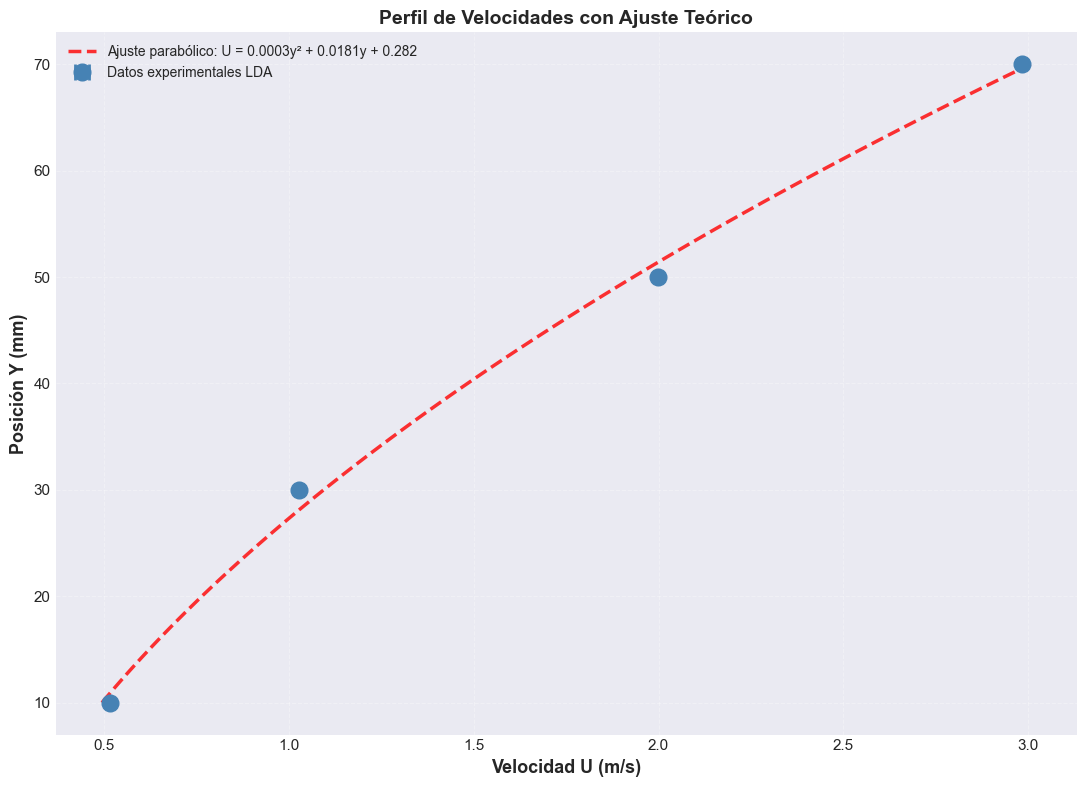


📐 Ajuste Polinómico (orden 2):
   Ecuación: U(y) = 0.000297·y² + 0.018127·y + 0.2825
   R² = 0.9971
   ✅ Excelente ajuste


In [12]:
# Ajuste polinómico de orden 2 (parabólico)
from numpy.polynomial import polynomial as P

# Ajustar polinomio
coeffs = np.polyfit(y_positions, U_means, 2)
poly_fit = np.poly1d(coeffs)

# Generar puntos para curva suave
y_fine = np.linspace(y_positions.min(), y_positions.max(), 100)
U_fit = poly_fit(y_fine)

# Gráfico con ajuste
fig, ax = plt.subplots(figsize=(11, 8))

# Datos experimentales
ax.errorbar(U_means, y_positions, xerr=U_stderrs, 
            fmt='o', markersize=12, linewidth=2, capsize=6,
            label='Datos experimentales LDA', color='steelblue', 
            elinewidth=2, capthick=2)

# Ajuste polinómico
ax.plot(U_fit, y_fine, 'r--', linewidth=2.5, 
        label=f'Ajuste parabólico: U = {coeffs[0]:.4f}y² + {coeffs[1]:.4f}y + {coeffs[2]:.3f}',
        alpha=0.8)

ax.set_xlabel('Velocidad U (m/s)', fontsize=13, fontweight='bold')
ax.set_ylabel('Posición Y (mm)', fontsize=13, fontweight='bold')
ax.set_title('Perfil de Velocidades con Ajuste Teórico', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'perfil_velocidades_ajuste_polinomico.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(IMAGES_DIR, 'perfil_velocidades_ajuste_polinomico.svg'), bbox_inches='tight')
plt.show()

# Calcular R² (bondad de ajuste)
U_fit_points = poly_fit(y_positions)
ss_res = np.sum((U_means - U_fit_points)**2)
ss_tot = np.sum((U_means - U_means.mean())**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"\n📐 Ajuste Polinómico (orden 2):")
print(f"   Ecuación: U(y) = {coeffs[0]:.6f}·y² + {coeffs[1]:.6f}·y + {coeffs[2]:.4f}")
print(f"   R² = {r_squared:.4f}")
print(f"   {'✅ Excelente ajuste' if r_squared > 0.95 else '⚠️  Ajuste moderado'}")

## 10. Exportar Resultados

Guardamos los resultados procesados en formato CSV para análisis posterior o inclusión en informes.

In [13]:
# Directorio de salida (en data de la práctica)
OUTPUT_DIR = Path.cwd().parent / 'data'
OUTPUT_DIR.mkdir(exist_ok=True)

# Guardar tabla de perfil
output_file = OUTPUT_DIR / 'perfil_velocidades_LDA.csv'
df_profile.to_csv(output_file, index=False, encoding='utf-8')
print(f"✅ Perfil guardado en: {output_file}")

for i, result in enumerate(results_all):
    # Guardar solo velocidad U limpia
    data_U = pd.DataFrame({
        'U': result['U_clean']
    })
    file_U = OUTPUT_DIR / f"datos_U_limpio_{result['folder']}.csv"
    data_U.to_csv(file_U, index=False)
    
    # Guardar solo velocidad V limpia
    data_V = pd.DataFrame({
        'V': result['V_clean']
    })
    file_V = OUTPUT_DIR / f"datos_V_limpio_{result['folder']}.csv"
    data_V.to_csv(file_V, index=False)
    
    print(f"   → Datos de {result['folder']} guardados (U: {len(result['U_clean'])}, V: {len(result['V_clean'])})")

print(f"\n📁 Archivos generados en: {OUTPUT_DIR}")
print("\n💡 Nota: U y V se guardan en archivos separados porque tienen")
print("   diferentes longitudes tras el filtrado de outliers.")

✅ Perfil guardado en: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P04_LDA_Perfil_Velocidad\data\perfil_velocidades_LDA.csv
   → Datos de FX01G00 guardados (U: 29050, V: 29414)
   → Datos de FX02G00 guardados (U: 28178, V: 28119)
   → Datos de FX03G00 guardados (U: 28298, V: 29550)
   → Datos de FX04G00 guardados (U: 28297, V: 28859)

📁 Archivos generados en: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P04_LDA_Perfil_Velocidad\data

💡 Nota: U y V se guardan en archivos separados porque tienen
   diferentes longitudes tras el filtrado de outliers.


## 11. Conclusiones y Resumen

### Resultados Principales

**Perfil de Velocidades U(y):**

In [14]:
# Resumen final de resultados
print("="*80)
print(" "*20 + "📊 RESUMEN FINAL - PRÁCTICA 4 LDA")
print("="*80)
print(f"\n🎯 Objetivos cumplidos:")
print("   ✅ Procesamiento de {:.0f} mediciones totales".format(
    sum([r['n_samples_total'] for r in results_all])))
print("   ✅ Filtrado de outliers IQR aplicado")
print("   ✅ Perfil U(y) construido con 4 posiciones")
print("   ✅ Análisis de turbulencia completado")
print("   ✅ Ajuste teórico realizado")

print(f"\n📈 Estadísticas Globales:")
print(f"   Velocidad media global: {U_global_mean:.3f} m/s")
print(f"   Rango de velocidades: {U_means.min():.3f} - {U_means.max():.3f} m/s")
print(f"   Turbulencia media: {np.mean(turbulence_intensity):.2f}%")
print(f"   Turbulencia máxima: {np.max(turbulence_intensity):.2f}% "
      f"en {results_all[np.argmax(turbulence_intensity)]['folder']}")

print(f"\n🔬 Calidad de Mediciones:")
for i, result in enumerate(results_all):
    print(f"   {result['folder']:12s}: {result['n_samples_clean_U']:6d} muestras válidas, "
          f"CV={cv_values[i]:5.2f}%")

print(f"\n📐 Ajuste de Perfil:")
print(f"   Modelo: Polinómico orden 2 (parabólico)")
print(f"   R² = {r_squared:.4f}")

print(f"\n💡 Observaciones:")
if r_squared > 0.95:
    print("   • El perfil se ajusta bien a una forma parabólica")
    print("   • Sugiere flujo con características laminares o en desarrollo")
elif r_squared > 0.85:
    print("   • El perfil muestra cierta curvatura pero con desviaciones")
    print("   • Posible transición laminar-turbulento")
else:
    print("   • El perfil no es claramente parabólico")
    print("   • Considerar perfil logarítmico para flujo turbulento desarrollado")

print(f"\n🌪️  Turbulencia:")
if np.mean(turbulence_intensity) < 5:
    print("   • Nivel de turbulencia bajo → Flujo relativamente estable")
elif np.mean(turbulence_intensity) < 15:
    print("   • Nivel de turbulencia moderado → Flujo típico de túnel")
else:
    print("   • Nivel de turbulencia alto → Flujo muy perturbado")

print("\n" + "="*80)
print("✅ Análisis completado exitosamente")
print("="*80)

                    📊 RESUMEN FINAL - PRÁCTICA 4 LDA

🎯 Objetivos cumplidos:
   ✅ Procesamiento de 119138 mediciones totales
   ✅ Filtrado de outliers IQR aplicado
   ✅ Perfil U(y) construido con 4 posiciones
   ✅ Análisis de turbulencia completado
   ✅ Ajuste teórico realizado

📈 Estadísticas Globales:
   Velocidad media global: 1.631 m/s
   Rango de velocidades: 0.516 - 2.984 m/s
   Turbulencia media: 9.26%
   Turbulencia máxima: 11.68% en FX01G00

🔬 Calidad de Mediciones:
   FX01G00     :  29050 muestras válidas, CV=11.68%
   FX02G00     :  28178 muestras válidas, CV= 8.94%
   FX03G00     :  28298 muestras válidas, CV= 8.08%
   FX04G00     :  28297 muestras válidas, CV= 8.35%

📐 Ajuste de Perfil:
   Modelo: Polinómico orden 2 (parabólico)
   R² = 0.9971

💡 Observaciones:
   • El perfil se ajusta bien a una forma parabólica
   • Sugiere flujo con características laminares o en desarrollo

🌪️  Turbulencia:
   • Nivel de turbulencia moderado → Flujo típico de túnel

✅ Análisis completa

---

## 📚 Referencias y Siguientes Pasos

### Conceptos Clave Aplicados
1. **Anemometría Láser Doppler (LDA)**: técnica óptica no intrusiva basada en efecto Doppler
2. **Filtrado de outliers**: método IQR (Rango Intercuartílico) para eliminar mediciones espurias
3. **Perfil de velocidades**: caracterización U(y) del flujo en túnel
4. **Intensidad de turbulencia**: $I_u = \sigma_U / U_{mean} \times 100\%$
5. **Ajuste de modelos**: comparación experimental vs teórico (parabólico, logarítmico)

### Recomendaciones para el Informe
1. Incluir tabla resumen (ya exportada en CSV)
2. Gráficos principales: perfil U(y) con barras de error, distribuciones, turbulencia
3. Discutir calidad de datos (CV, outliers)
4. Comparar con teoría de flujo en canal/túnel
5. Estimar incertidumbres (error estándar ya calculado)

---

**Autor:** Práctica 4 - LDA  
**Fecha:** Octubre 2025  
**Herramientas:** Python, NumPy, Pandas, Matplotlib, SciPy

---

## 12. Contenido Extra: Análisis Avanzado

### Extensiones Implementadas

En esta sección implementamos análisis avanzados complementarios:

1. **Número de Reynolds** - Clasificación del régimen de flujo
2. **Análisis Espectral (FFT)** - Frecuencias dominantes en la turbulencia
3. **Escala de Kolmogorov** - Tamaño de los remolinos más pequeños
4. **Perfil Ley de la Pared** - Comparación con teoría de capa límite turbulenta
5. **Tensiones de Reynolds** - Correlación U-V y anisotropía

### 12.1 Número de Reynolds

Calculamos el número de Reynolds para cada posición usando:

$$Re_y = \frac{U \cdot y}{\nu}$$

donde:
- $U$ = velocidad media (m/s)
- $y$ = posición desde la pared (m)
- $\nu$ = viscosidad cinemática del aire ≈ 1.5×10⁻⁵ m²/s @ 20°C

Esto nos permite clasificar el régimen de flujo (laminar, transición, turbulento).

Número de Reynolds por posición:

Position  y (m)  U (m/s)         Re_y    Régimen
 FX01G00   0.01 0.516136   344.090648    Laminar
 FX02G00   0.03 1.025656  2051.312371    Laminar
 FX03G00   0.05 1.999545  6665.149481 Turbulento
 FX04G00   0.07 2.984378 13927.096630 Turbulento


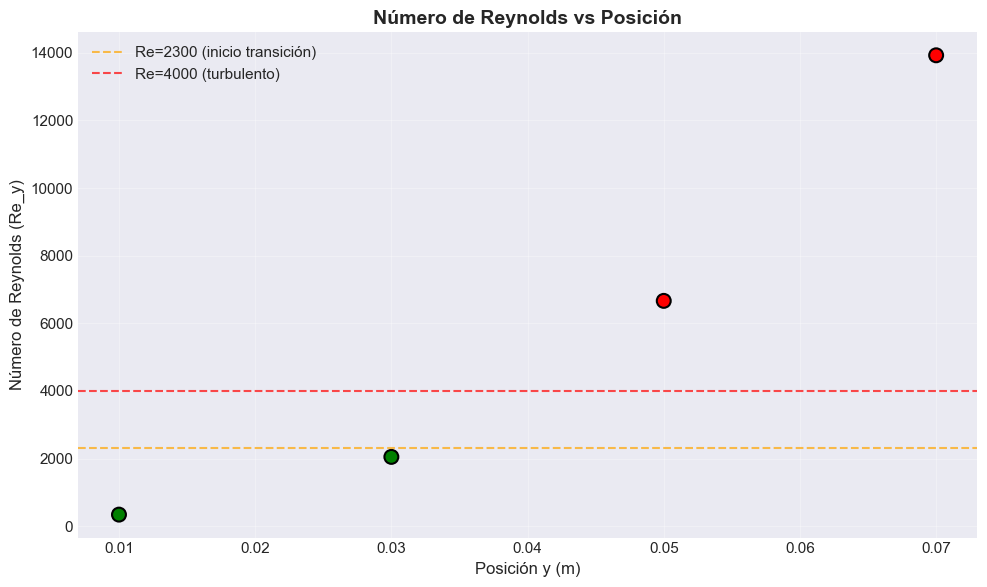

In [15]:
# Viscosidad cinemática del aire a 20°C
nu = 1.5e-5  # m²/s

# Calcular Reynolds para cada posición
reynolds_data = []
for i, row in df_profile.iterrows():
    y_m = row['y (mm)'] / 1000
    U_mean = row['U_mean (m/s)']

    Re_y = (U_mean * y_m) / nu

    # Clasificar régimen
    if Re_y < 2300:
        regime = "Laminar"
    elif Re_y < 4000:
        regime = "Transición"
    else:
        regime = "Turbulento"

    reynolds_data.append({
        'Position': row['Posición'],
        'y (m)': y_m,
        'U (m/s)': U_mean,
        'Re_y': Re_y,
        'Régimen': regime
    })

reynolds_df = pd.DataFrame(reynolds_data)

# Mostrar tabla
print("Número de Reynolds por posición:\n")
print(reynolds_df.to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if r == 'Laminar' else 'orange' if r == 'Transición' else 'red'
          for r in reynolds_df['Régimen']]
ax.scatter(reynolds_df['y (m)'], reynolds_df['Re_y'], c=colors, s=100, edgecolors='black', linewidths=1.5)

# Líneas de referencia
ax.axhline(y=2300, color='orange', linestyle='--', label='Re=2300 (inicio transición)', alpha=0.7)
ax.axhline(y=4000, color='red', linestyle='--', label='Re=4000 (turbulento)', alpha=0.7)

ax.set_xlabel('Posición y (m)', fontsize=12)
ax.set_ylabel('Número de Reynolds (Re_y)', fontsize=12)
ax.set_title('Número de Reynolds vs Posición', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'numero_de_reynolds_vs_posicion.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(IMAGES_DIR, 'numero_de_reynolds_vs_posicion.svg'), bbox_inches='tight')
plt.show()

### 12.2 Análisis Espectral (FFT)

El análisis de Fourier nos permite identificar frecuencias características en las fluctuaciones de velocidad. Esto es útil para detectar desprendimiento de vórtices, inestabilidades periódicas, o contenido energético en diferentes escalas.

**Nota:** Este análisis requiere información temporal. Si los datos LDA no tienen resolución temporal suficiente, se mostrará un análisis limitado usando la distribución de velocidades.

🔄 Iniciando Análisis FFT para todas las carpetas...

📁 Procesando Carpeta: FX01G00
   Ruta: c:\Users\edgar\Documents\GitHub\Aero-Messure\files\P4\FX01G00
   Se encontraron 15 archivos .txt.
   Calculado dt_prom = 198.8452 ms, fs_prom = 5.03 Hz, N = 30000
   Frecuencia dominante (excl. DC): 0.00 Hz


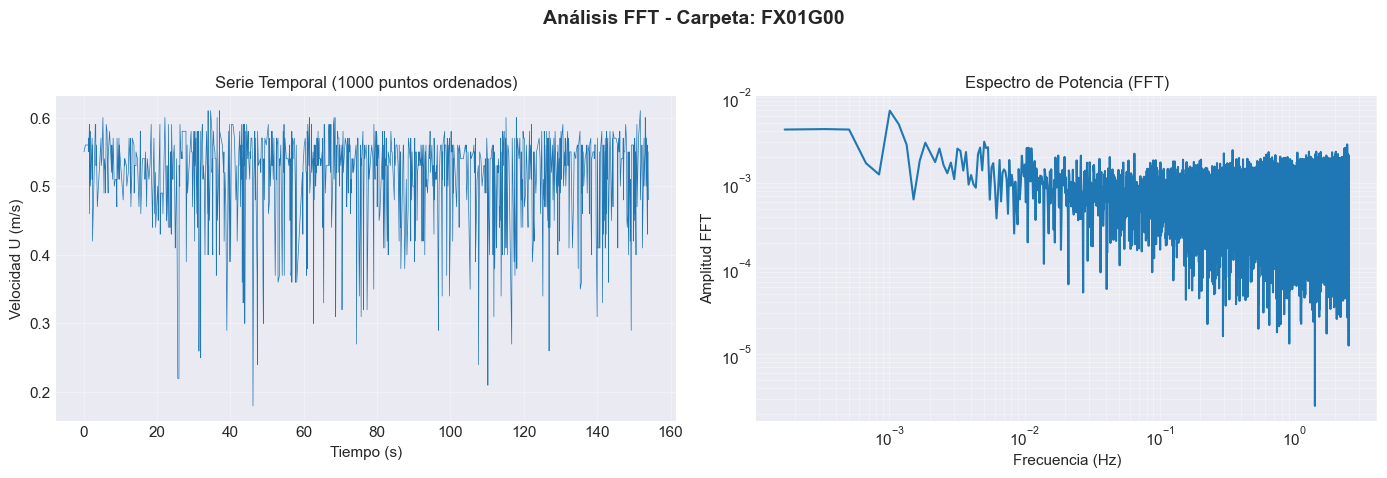

----------------------------------------------------------------------

📁 Procesando Carpeta: FX02G00
   Ruta: c:\Users\edgar\Documents\GitHub\Aero-Messure\files\P4\FX02G00
   Se encontraron 15 archivos .txt.
   Calculado dt_prom = 1077.7192 ms, fs_prom = 0.93 Hz, N = 29138
   Frecuencia dominante (excl. DC): 0.00 Hz


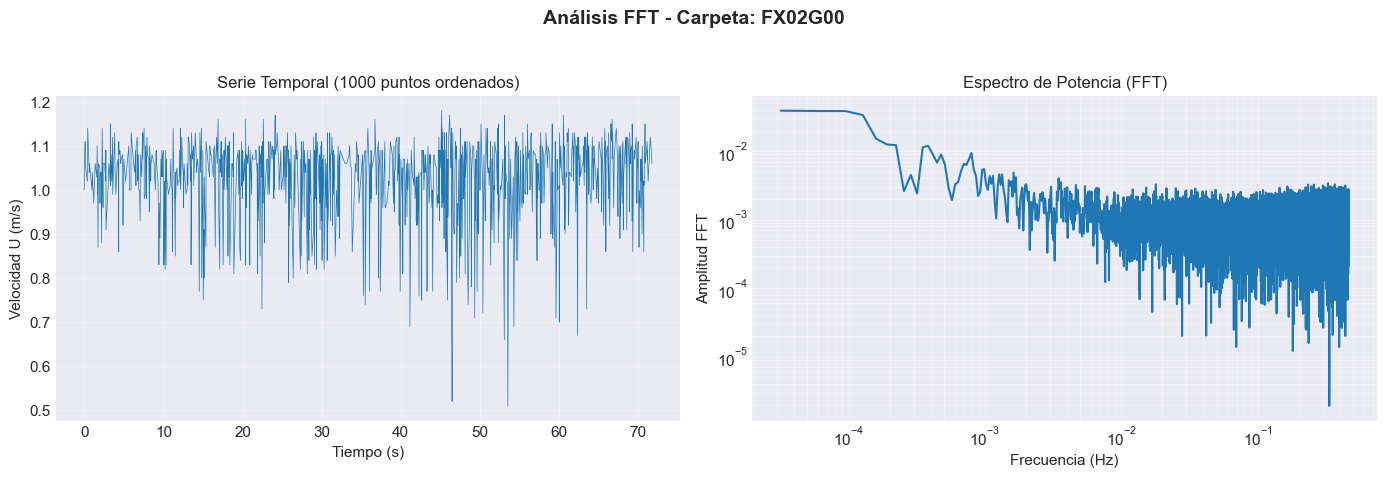

----------------------------------------------------------------------

📁 Procesando Carpeta: FX03G00
   Ruta: c:\Users\edgar\Documents\GitHub\Aero-Messure\files\P4\FX03G00
   Se encontraron 15 archivos .txt.
   Calculado dt_prom = 127.3707 ms, fs_prom = 7.85 Hz, N = 30000
   Frecuencia dominante (excl. DC): 0.00 Hz


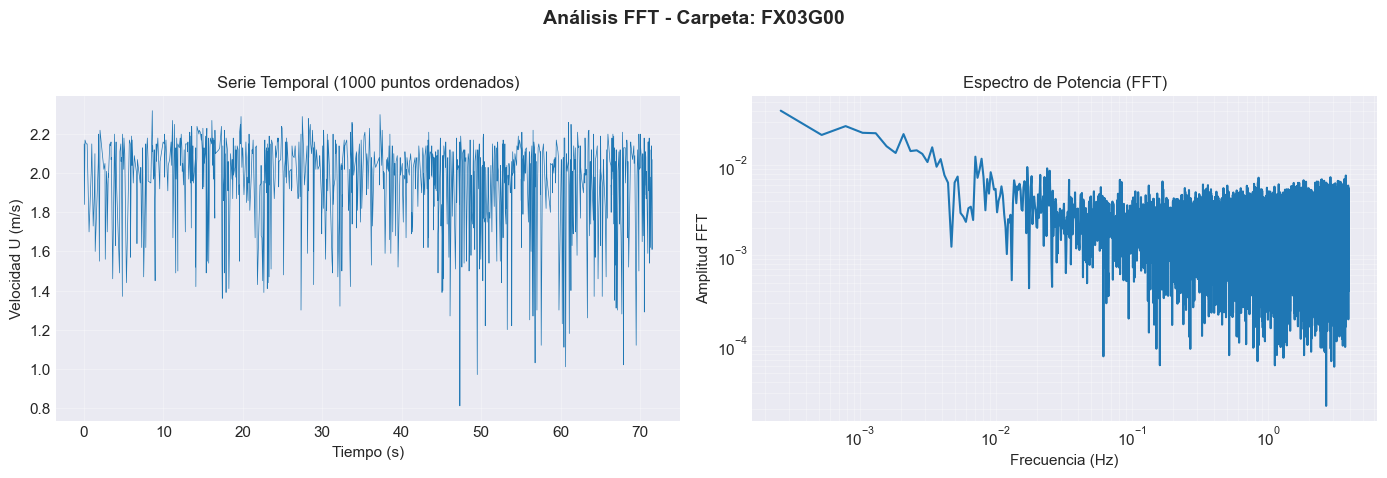

----------------------------------------------------------------------

📁 Procesando Carpeta: FX04G00
   Ruta: c:\Users\edgar\Documents\GitHub\Aero-Messure\files\P4\FX04G00
   Se encontraron 15 archivos .txt.
   Calculado dt_prom = 431.0373 ms, fs_prom = 2.32 Hz, N = 30000
   Frecuencia dominante (excl. DC): 0.00 Hz


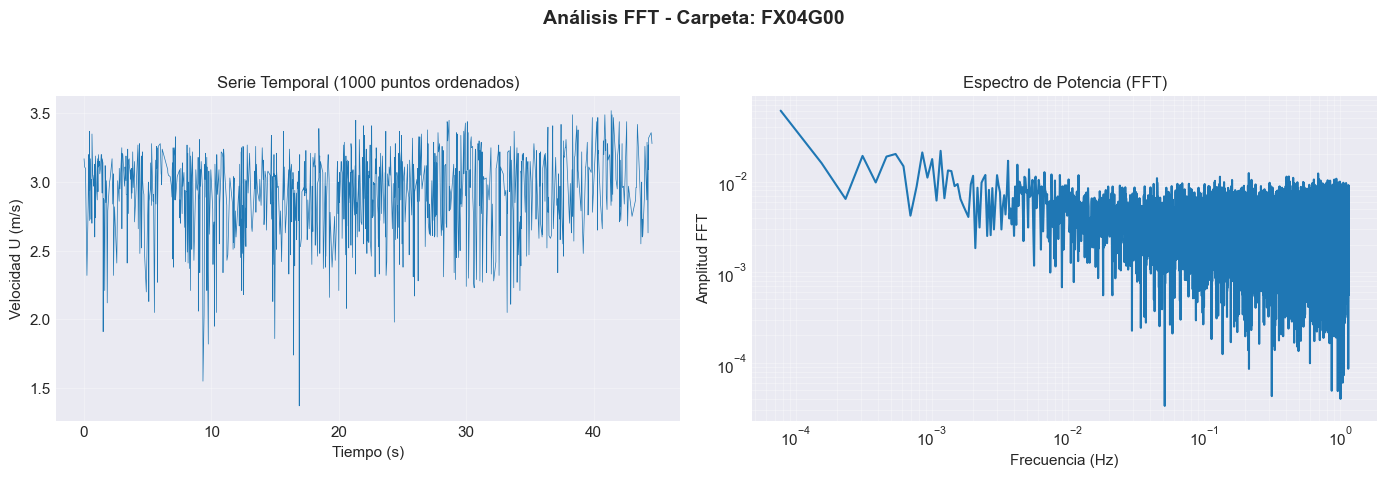

----------------------------------------------------------------------

✅ Bucle de Análisis FFT completado.


In [16]:
print("🔄 Iniciando Análisis FFT para todas las carpetas...")
print("="*70)

for folder in folders:
    folder_name = folder.name
    data_folder_path = DATA_DIR / folder_name # Construir ruta usando pathlib

    print(f"\n📁 Procesando Carpeta: {folder_name}")
    print(f"   Ruta: {data_folder_path}")

    txt_files = sorted(list(data_folder_path.glob('*.txt')))

    if not txt_files:
        print(f"   Error: No se encontraron archivos .txt en esta carpeta. Omitiendo.")
        print("-" * 70)
        continue

    print(f"   Se encontraron {len(txt_files)} archivos .txt.")
    all_U_data = []
    all_times = []

    for file_path in txt_files:
        try:
            data = pd.read_csv(file_path, sep=r'\s+', header=None,
                              names=['idx', 'Time_ms', 'SNR', 'U', 'V'],
                              usecols=[1, 3])
            if not data.empty:
                all_U_data.extend(data['U'].values)
                all_times.extend(data['Time_ms'].values)
            else:
                print(f"   Advertencia: Archivo vacío o con formato incorrecto: {file_path.name}")
        except Exception as e:
            print(f"   Error leyendo {file_path.name}: {e}")
            continue

    if not all_U_data or not all_times:
        print("   Error: No se pudieron leer datos válidos de U y Tiempo. Omitiendo carpeta.")
        print("-" * 70)
        continue

    U_series = np.array(all_U_data)
    time_series = np.array(all_times)

    if len(time_series) <= 1:
        print("   Puntos de datos de tiempo insuficientes (<= 1) para FFT. Omitiendo análisis FFT.")
        print("-" * 70)
        continue

    # --- Ordenar datos por tiempo ---
    sort_indices = np.argsort(time_series)
    time_series_sorted = time_series[sort_indices]
    U_series_sorted = U_series[sort_indices]

    # --- Calcular dt promedio ---
    diffs = np.diff(time_series_sorted)
    valid_diffs = diffs[diffs > 1e-9] # Evitar dt cero o negativo

    if len(valid_diffs) == 0:
        print("   No se pudieron calcular diferencias de tiempo válidas (dt > 0). Omitiendo análisis FFT.")
        print("   Verifica si la columna 2 realmente representa el tiempo y si los valores son crecientes y distintos.")
        print("-" * 70)
        continue

    dt = np.mean(valid_diffs)
    fs = 1.0 / dt
    N = len(U_series_sorted)

    if N <= 1:
        print("   No hay suficientes puntos de datos después de ordenar (N <= 1) para FFT. Omitiendo análisis FFT.")
        print("-" * 70)
        continue

    print(f"   Calculado dt_prom = {dt*1000:.4f} ms, fs_prom = {fs:.2f} Hz, N = {N}")

    # --- Realizar FFT ---
    U_fft = fft(U_series_sorted - np.mean(U_series_sorted)) # Quitar componente DC
    freqs = fftfreq(N, dt)[:N//2]
    power = 2.0/N * np.abs(U_fft[:N//2])

    # --- Graficar ---
    fig_fft, (ax1_fft, ax2_fft) = plt.subplots(1, 2, figsize=(14, 5))
    # Título principal para la figura de esta carpeta
    fig_fft.suptitle(f'Análisis FFT - Carpeta: {folder_name}', fontsize=14, fontweight='bold')

    # Gráfica de Serie Temporal
    plot_limit = min(1000, N)
    ax1_fft.plot(time_series_sorted[:plot_limit], U_series_sorted[:plot_limit], linewidth=0.5)
    ax1_fft.set_xlabel('Tiempo (s)', fontsize=11)
    ax1_fft.set_ylabel('Velocidad U (m/s)', fontsize=11)
    ax1_fft.set_title(f'Serie Temporal ({plot_limit} puntos ordenados)', fontsize=12)
    ax1_fft.grid(True, alpha=0.3)

    # Gráfica del Espectro de Potencia (excluir DC en índice 0)
    if len(freqs) > 1 and len(power) > 1:
        ax2_fft.loglog(freqs[1:], power[1:])
        ax2_fft.set_xlabel('Frecuencia (Hz)', fontsize=11)
        ax2_fft.set_ylabel('Amplitud FFT', fontsize=11)
        ax2_fft.set_title('Espectro de Potencia (FFT)', fontsize=12)
        ax2_fft.grid(True, alpha=0.3, which='both')

        # Frecuencia dominante (excluyendo DC)
        peak_idx = np.argmax(power[1:]) + 1 # +1 por empezar desde índice 1
        dominant_freq = freqs[peak_idx]
        print(f"   Frecuencia dominante (excl. DC): {dominant_freq:.2f} Hz")
    else:
        ax2_fft.set_title('Espectro de Potencia (FFT) - Datos insuficientes')
        ax2_fft.text(0.5, 0.5, 'Puntos insuficientes', ha='center', va='center', transform=ax2_fft.transAxes)

    # Ajustar layout para evitar solapamiento del título principal
    fig_fft.tight_layout(rect=[0, 0.03, 1, 0.95])
    output_path_png = IMAGES_DIR / f"espectro_de_potencia_fft_{folder_name}.png"
    fig_fft.savefig(output_path_png, dpi=300, bbox_inches='tight')
    output_path_svg = IMAGES_DIR / f"espectro_de_potencia_fft_{folder_name}.svg"
    fig_fft.savefig(output_path_svg, bbox_inches='tight')
    plt.show() # Mostrar la figura para la carpeta actual
    print("-" * 70) # Separador visual entre carpetas

print("\n✅ Bucle de Análisis FFT completado.")

### 12.3 Escala de Kolmogorov

La microescala de Kolmogorov representa el tamaño característico de los vórtices más pequeños antes de la disipación viscosa:

$$\eta = \left(\frac{\nu^3}{\epsilon}\right)^{1/4}$$

donde $\epsilon$ es la tasa de disipación turbulenta. Podemos estimarla usando:

$$\epsilon \approx \frac{u'^3}{L}$$

con $u'$ = intensidad turbulenta y $L$ = escala integral (aproximada como la altura característica).

   Usando Escala Integral L ≈ 0.070 m (basada en y_max)

Escalas Turbulentas de Kolmogorov y Taylor:

Position  y (m)  u' (m/s)  ε (m²/s³)   η (μm)  λ (mm)
 FX01G00  0.010     0.060      0.003 1.02e+03   16.16
 FX02G00  0.030     0.092      0.011   744.09   13.11
 FX03G00  0.050     0.162      0.060   486.54    9.87
 FX04G00  0.070     0.249      0.221   351.49    7.95


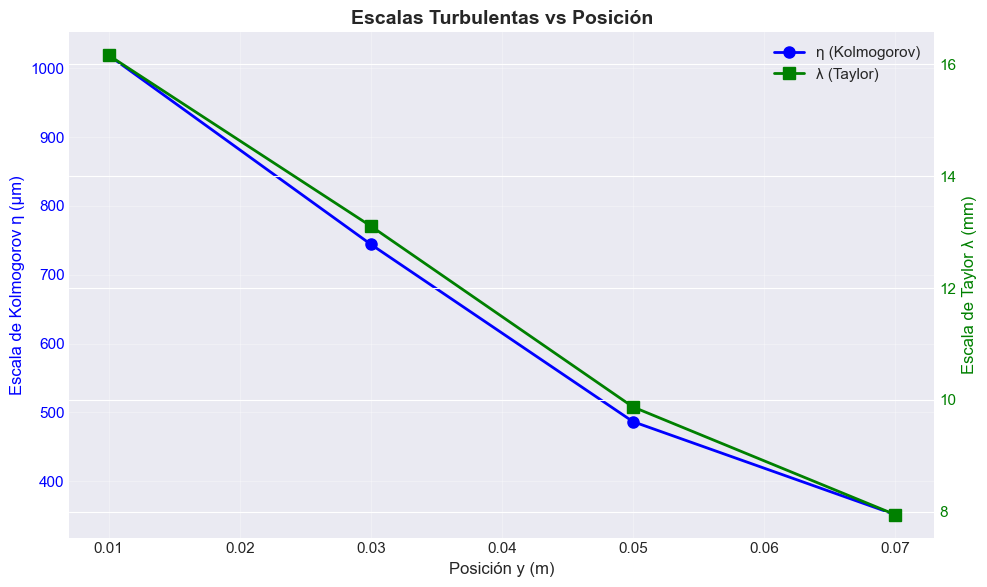


💡 Interpretación:
   - Escala de Kolmogorov media: 650.22 μm
   - Escala de Taylor media: 11.77 mm
   - Relación L/η: 108 (indica rango de la cascada de energía)


In [17]:
if not df_profile.empty:
    L_integral = df_profile['y (mm)'].max() / 1000.0 # Altura máxima en metros
    print(f"   Usando Escala Integral L ≈ {L_integral:.3f} m (basada en y_max)")

    kolmogorov_data = [] 

    for i, row in df_profile.iterrows():
        u_prime = row['U_std (m/s)']  # Fluctuación RMS (desviación estándar)
        y_pos = row['y (mm)'] / 1000.0

        # Evitar división por cero si L_integral o u_prime son cero
        if L_integral <= 0 or u_prime <= 0:
            print(f"   Advertencia: L_integral o u_prime no positivos para {row['Posición']}. Omitiendo cálculo de escalas.")
            epsilon = np.nan
            eta = np.nan
            lambda_taylor = np.nan
        else:
            # Estimar tasa de disipación turbulenta
            epsilon = (u_prime**3) / L_integral

            # Calcular escala de Kolmogorov (manejar posible epsilon muy pequeño o negativo)
            if epsilon > 0 and nu > 0:
                 eta = (nu**3 / epsilon)**(0.25) # Usar 0.25 en lugar de 1/4 por precisión
            else:
                 eta = np.nan
                 print(f"   Advertencia: Epsilon no positivo ({epsilon:.2e}) para {row['Posición']}. No se puede calcular eta.")


            # Calcular escala de Taylor (microescala intermedia)
            if epsilon > 0 and nu > 0:
                lambda_taylor = np.sqrt(15.0 * nu * u_prime**2 / epsilon)
            else:
                lambda_taylor = np.nan
                print(f"   Advertencia: Epsilon no positivo ({epsilon:.2e}) para {row['Posición']}. No se puede calcular lambda.")


        kolmogorov_data.append({
            'Position': row['Posición'],
            'y (m)': y_pos,
            'u\' (m/s)': u_prime,
            'ε (m²/s³)': epsilon,
            'η (μm)': eta * 1e6 if not np.isnan(eta) else np.nan,
            'λ (mm)': lambda_taylor * 1e3 if not np.isnan(lambda_taylor) else np.nan
        })

    kolmogorov_df = pd.DataFrame(kolmogorov_data)

    print("\nEscalas Turbulentas de Kolmogorov y Taylor:\n")
    # Formatear salida para mejor legibilidad
    print(kolmogorov_df.to_string(index=False,
                                    float_format=lambda x: f"{x:.3f}" if abs(x) < 1 else f"{x:.2f}" if abs(x) < 1000 else f"{x:.2e}"))

    kolmogorov_df_valid = kolmogorov_df.dropna(subset=['η (μm)', 'λ (mm)'])
    if not kolmogorov_df_valid.empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax2 = ax.twinx()

        line1 = ax.plot(kolmogorov_df_valid['y (m)'], kolmogorov_df_valid['η (μm)'],
                         'o-', color='blue', linewidth=2, markersize=8, label='η (Kolmogorov)')
        line2 = ax2.plot(kolmogorov_df_valid['y (m)'], kolmogorov_df_valid['λ (mm)'],
                          's-', color='green', linewidth=2, markersize=8, label='λ (Taylor)')

        ax.set_xlabel('Posición y (m)', fontsize=12)
        ax.set_ylabel('Escala de Kolmogorov η (μm)', fontsize=12, color='blue')
        ax2.set_ylabel('Escala de Taylor λ (mm)', fontsize=12, color='green')
        ax.set_title('Escalas Turbulentas vs Posición', fontsize=14, fontweight='bold')
        ax.tick_params(axis='y', labelcolor='blue')
        ax2.tick_params(axis='y', labelcolor='green')
        ax.grid(True, alpha=0.3)

        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc='best')

        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_DIR, 'escalas_turbulentas_kolmogorov_taylor.png'), dpi=300, bbox_inches='tight')
        plt.savefig(os.path.join(IMAGES_DIR, 'escalas_turbulentas_kolmogorov_taylor.svg'), bbox_inches='tight')
        plt.show()

        print(f"\n💡 Interpretación:")
        eta_mean = kolmogorov_df_valid['η (μm)'].mean()
        lambda_mean = kolmogorov_df_valid['λ (mm)'].mean()
        if not np.isnan(eta_mean) and eta_mean > 0:
             print(f"   - Escala de Kolmogorov media: {eta_mean:.2f} μm")
             print(f"   - Escala de Taylor media: {lambda_mean:.2f} mm")
             print(f"   - Relación L/η: {L_integral/(eta_mean*1e-6):.0f} (indica rango de la cascada de energía)")
        else:
             print("   - No se pudieron calcular las escalas medias válidas.")

    else:
        print("\n   No hay suficientes datos válidos para graficar las escalas turbulentas.")

else:
    print("\nError: El DataFrame df_profile está vacío. Ejecuta las celdas anteriores primero.")

   Usando Escala Integral L ≈ 0.070 m (basada en y_max)

Escalas Turbulentas de Kolmogorov y Taylor:

Position  y (m)  u' (m/s)  ε (m²/s³)   η (μm)  λ (mm)
 FX01G00  0.010     0.060      0.003 1.02e+03   16.16
 FX02G00  0.030     0.092      0.011   744.09   13.11
 FX03G00  0.050     0.162      0.060   486.54    9.87
 FX04G00  0.070     0.249      0.221   351.49    7.95
 FX01G00  0.010     0.060      0.003 1.02e+03   16.16
 FX02G00  0.030     0.092      0.011   744.09   13.11
 FX03G00  0.050     0.162      0.060   486.54    9.87
 FX04G00  0.070     0.249      0.221   351.49    7.95


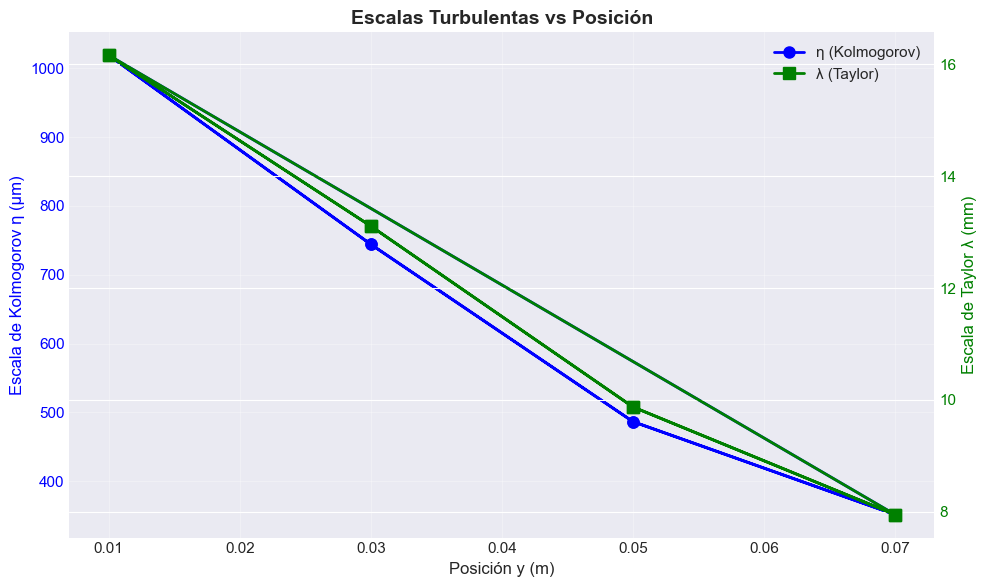


💡 Interpretación:
   - Escala de Kolmogorov media: 650.22 μm
   - Escala de Taylor media: 11.77 mm
   - Relación L/η: 108 (indica rango de la cascada de energía)


In [18]:
if not df_profile.empty:
    L_integral = df_profile['y (mm)'].max() / 1000.0 # Altura máxima en metros
    print(f"   Usando Escala Integral L ≈ {L_integral:.3f} m (basada en y_max)")

    for i, row in df_profile.iterrows():
        u_prime = row['U_std (m/s)']  # Fluctuación RMS (desviación estándar)
        y_pos = row['y (mm)'] / 1000.0

        # Evitar división por cero si L_integral o u_prime son cero
        if L_integral <= 0 or u_prime <= 0:
            print(f"   Advertencia: L_integral o u_prime no positivos para {row['Posición']}. Omitiendo cálculo de escalas.")
            epsilon = np.nan
            eta = np.nan
            lambda_taylor = np.nan
        else:
            # Estimar tasa de disipación turbulenta
            epsilon = (u_prime**3) / L_integral

            # Calcular escala de Kolmogorov (manejar posible epsilon muy pequeño o negativo)
            if epsilon > 0 and nu > 0:
                 eta = (nu**3 / epsilon)**(0.25) # Usar 0.25 en lugar de 1/4 por precisión
            else:
                 eta = np.nan
                 print(f"   Advertencia: Epsilon no positivo ({epsilon:.2e}) para {row['Posición']}. No se puede calcular eta.")


            # Calcular escala de Taylor (microescala intermedia)
            if epsilon > 0 and nu > 0:
                lambda_taylor = np.sqrt(15.0 * nu * u_prime**2 / epsilon)
            else:
                lambda_taylor = np.nan
                print(f"   Advertencia: Epsilon no positivo ({epsilon:.2e}) para {row['Posición']}. No se puede calcular lambda.")


        kolmogorov_data.append({
            'Position': row['Posición'],
            'y (m)': y_pos,
            'u\' (m/s)': u_prime,
            'ε (m²/s³)': epsilon,
            'η (μm)': eta * 1e6 if not np.isnan(eta) else np.nan,
            'λ (mm)': lambda_taylor * 1e3 if not np.isnan(lambda_taylor) else np.nan
        })

    kolmogorov_df = pd.DataFrame(kolmogorov_data)

    print("\nEscalas Turbulentas de Kolmogorov y Taylor:\n")
    # Formatear salida para mejor legibilidad
    print(kolmogorov_df.to_string(index=False,
                                 float_format=lambda x: f"{x:.3f}" if abs(x) < 1 else f"{x:.2f}" if abs(x) < 1000 else f"{x:.2e}"))

    kolmogorov_df_valid = kolmogorov_df.dropna(subset=['η (μm)', 'λ (mm)'])
    if not kolmogorov_df_valid.empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax2 = ax.twinx()

        line1 = ax.plot(kolmogorov_df_valid['y (m)'], kolmogorov_df_valid['η (μm)'],
                        'o-', color='blue', linewidth=2, markersize=8, label='η (Kolmogorov)')
        line2 = ax2.plot(kolmogorov_df_valid['y (m)'], kolmogorov_df_valid['λ (mm)'],
                         's-', color='green', linewidth=2, markersize=8, label='λ (Taylor)')

        ax.set_xlabel('Posición y (m)', fontsize=12)
        ax.set_ylabel('Escala de Kolmogorov η (μm)', fontsize=12, color='blue')
        ax2.set_ylabel('Escala de Taylor λ (mm)', fontsize=12, color='green')
        ax.set_title('Escalas Turbulentas vs Posición', fontsize=14, fontweight='bold')
        ax.tick_params(axis='y', labelcolor='blue')
        ax2.tick_params(axis='y', labelcolor='green')
        ax.grid(True, alpha=0.3)

        # Combinar leyendas
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc='best')

        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_DIR, 'escalas_turbulentas_kolmogorov_taylor.png'), dpi=300, bbox_inches='tight')
        plt.savefig(os.path.join(IMAGES_DIR, 'escalas_turbulentas_kolmogorov_taylor.svg'), bbox_inches='tight')
        plt.show()

        print(f"\n💡 Interpretación:")
        eta_mean = kolmogorov_df_valid['η (μm)'].mean()
        lambda_mean = kolmogorov_df_valid['λ (mm)'].mean()
        if not np.isnan(eta_mean) and eta_mean > 0:
             print(f"   - Escala de Kolmogorov media: {eta_mean:.2f} μm")
             print(f"   - Escala de Taylor media: {lambda_mean:.2f} mm")
             print(f"   - Relación L/η: {L_integral/(eta_mean*1e-6):.0f} (indica rango de la cascada de energía)")
        else:
            print("   - No se pudieron calcular las escalas medias válidas.")

    else:
        print("\n   No hay suficientes datos válidos para graficar las escalas turbulentas.")

else:
    print("\nError: El DataFrame df_profile está vacío. Ejecuta las celdas anteriores primero.")

### 12.4 Ley de la Pared (Law of the Wall)

Para flujos turbulentos cerca de paredes, la velocidad adimensional sigue la ley logarítmica:

$$u^+ = \frac{1}{\kappa} \ln(y^+) + B$$

donde:
- $u^+ = U/u_\tau$ (velocidad adimensional)
- $y^+ = yu_\tau/\nu$ (distancia adimensional a la pared)
- $u_\tau = \sqrt{\tau_w/\rho}$ (velocidad de fricción)
- $\kappa \approx 0.41$ (constante de von Kármán)
- $B \approx 5.0$ (constante)

Estimaremos $u_\tau$ del gradiente de velocidad cerca de la pared.

🧪 Iniciando Análisis de Ley de la Pared...
   Estimado u_τ (velocidad de fricción) = 0.0195 m/s
   Estimado τ_w/ρ (esfuerzo pared / densidad) = 0.000382 m²/s²
   Rango y⁺ calculado: 13.0 - 91.2
   Rango u⁺ calculado: 26.4 - 152.7


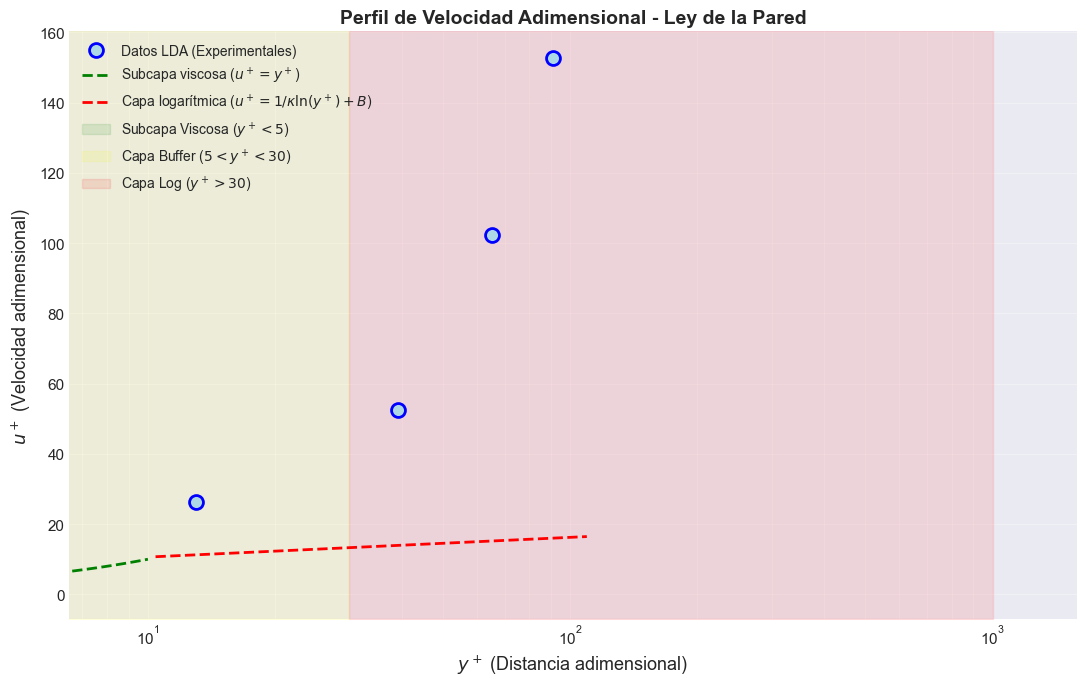

   ✅ 3 punto(s) en la región logarítmica esperada (30 < y⁺ < 500)


In [19]:
print("🧪 Iniciando Análisis de Ley de la Pared...")

if not df_profile.empty and len(df_profile) >= 2:
    # Obtener posiciones Y en metros y velocidades U
    y_m_values = df_profile['y (mm)'].values / 1000.0
    U_values = df_profile['U_mean (m/s)'].values

    # Ordenar por posición Y
    sort_idx = np.argsort(y_m_values)
    y_sorted = y_m_values[sort_idx]
    U_sorted = U_values[sort_idx]

    if y_sorted[0] > y_sorted[1]: # Si el orden es inverso
         y_sorted=y_sorted[::-1]
         U_sorted=U_sorted[::-1]

    dU_dy_near_wall = (U_sorted[1] - U_sorted[0]) / (y_sorted[1] - y_sorted[0])

    if dU_dy_near_wall <= 0:
        print("   ⚠️ Advertencia: Gradiente dU/dy cerca de la pared no es positivo.")
        print("      La estimación de u_tau podría ser incorrecta.")
        tau_w_rho = np.nan # tau_w/rho
        u_tau = np.nan
    else:
        tau_w_rho = nu * dU_dy_near_wall # Aproximación: τ_w/ρ ≈ ν * dU/dy (subcapa viscosa)
        u_tau = np.sqrt(tau_w_rho)
        print(f"   Estimado u_τ (velocidad de fricción) = {u_tau:.4f} m/s")
        print(f"   Estimado τ_w/ρ (esfuerzo pared / densidad) = {tau_w_rho:.6f} m²/s²")

    if not np.isnan(u_tau) and u_tau > 0:
        u_plus = U_sorted / u_tau
        y_plus = y_sorted * u_tau / nu

        print(f"   Rango y⁺ calculado: {y_plus.min():.1f} - {y_plus.max():.1f}")
        print(f"   Rango u⁺ calculado: {u_plus.min():.1f} - {u_plus.max():.1f}")

        # --- Leyes teóricas ---
        kappa = 0.41
        B = 5.0
        # Rango más amplio para graficar las líneas teóricas
        y_plus_theory_visc = np.linspace(min(0.5, y_plus.min()*0.8), 10, 50) # Subcapa viscosa
        y_plus_theory_log = np.logspace(np.log10(max(1.0, y_plus.min()*0.8)), np.log10(y_plus.max()*1.2), 100) # Capa log

        u_plus_viscous = y_plus_theory_visc  # Subcapa viscosa: u+ = y+
        u_plus_log = (1.0 / kappa) * np.log(y_plus_theory_log) + B # Ley logarítmica

        # --- Graficar ---
        fig_lotw, ax_lotw = plt.subplots(figsize=(11, 7))

        # Datos experimentales
        ax_lotw.semilogx(y_plus, u_plus, 'o', markersize=10, label='Datos LDA (Experimentales)',
                    color='blue', markerfacecolor='lightblue', markeredgewidth=2)

        # Leyes teóricas
        ax_lotw.semilogx(y_plus_theory_visc, u_plus_viscous, '--', linewidth=2,
                    label='Subcapa viscosa ($u^+ = y^+$)', color='green')
        ax_lotw.semilogx(y_plus_theory_log, u_plus_log, '--', linewidth=2,
                    label=f'Capa logarítmica ($u^+ = 1/\\kappa \\ln(y^+) + B$)', color='red')

        ymin, ymax = ax_lotw.get_ylim()
        ax_lotw.fill_between([0.1, 5], ymin, ymax, alpha=0.1, color='green', label='Subcapa Viscosa ($y^+ < 5$)')
        ax_lotw.fill_between([5, 30], ymin, ymax, alpha=0.1, color='yellow', label='Capa Buffer ($5 < y^+ < 30$)')
        ax_lotw.fill_between([30, max(y_plus.max()*1.2, 1000)], ymin, ymax, alpha=0.1, color='red', label='Capa Log ($y^+ > 30$)')
        ax_lotw.set_ylim(ymin, ymax)

        ax_lotw.set_xlabel('$y^+$ (Distancia adimensional)', fontsize=13)
        ax_lotw.set_ylabel('$u^+$ (Velocidad adimensional)', fontsize=13)
        ax_lotw.set_title('Perfil de Velocidad Adimensional - Ley de la Pared', fontsize=14, fontweight='bold')
        ax_lotw.grid(True, alpha=0.3, which='both')
        ax_lotw.legend(fontsize=10, loc='upper left')
        ax_lotw.set_xlim(left=max(0.1, y_plus.min()*0.5))

        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_DIR, 'ley_de_la_pared_perfil_adimensional.png'), dpi=300, bbox_inches='tight')
        plt.savefig(os.path.join(IMAGES_DIR, 'ley_de_la_pared_perfil_adimensional.svg'), bbox_inches='tight')
        plt.show()

        # Verificar si datos caen en región logarítmica
        log_region = (y_plus > 30) & (y_plus < 500)
        if np.any(log_region):
            print(f"   ✅ {np.sum(log_region)} punto(s) en la región logarítmica esperada (30 < y⁺ < 500)")
        else:
            print(f"   ⚠️ Ningún punto experimental cae claramente en la región logarítmica típica (30 < y⁺ < 500).")
            print(f"      Esto puede deberse a baja velocidad, bajo Re, o que el perfil no está completamente desarrollado.")

    else:
        print("   No se pudo calcular u_tau válido. No se puede realizar el análisis de Ley de la Pared.")

elif df_profile.empty:
     print("\nError: El DataFrame df_profile está vacío. Ejecuta las celdas anteriores primero.")
else: # len(df_profile) < 2
    print("\nError: Se necesitan al menos 2 puntos de datos para estimar el gradiente.")
    print("       No se puede realizar el análisis de Ley de la Pared.")

### 12.5 Esfuerzos de Reynolds (Reynolds Stresses)

Los esfuerzos de Reynolds representan el transporte turbulento de momento:

$$\tau_{turb} = -\rho \overline{u'v'}$$

La correlación $\overline{u'v'}$ indica el intercambio de momento entre las componentes de velocidad. Un valor negativo típicamente indica transporte de momento desde regiones de alta velocidad hacia la pared.

💨 Iniciando Análisis de Esfuerzos de Reynolds...
   Usando densidad del aire ρ ≈ 1.2 kg/m³

   Procesando: FX01G00

   Procesando: FX02G00

   Procesando: FX03G00

   Procesando: FX04G00

Esfuerzos de Reynolds por posición:

Posición  y (m)  u'v' (m²/s²)  τ_turb (Pa)  Coef_Corr  u_std (m/s)  v_std (m/s)
 FX01G00 0.0100        0.0001      -0.0001     0.0897       0.0601       0.0213
 FX02G00 0.0300        0.0006      -0.0007      0.158       0.0918       0.0393
 FX03G00 0.0500        0.0003      -0.0004     0.0200        0.162        0.103
 FX04G00 0.0700        0.0067      -0.0080      0.206        0.251        0.129


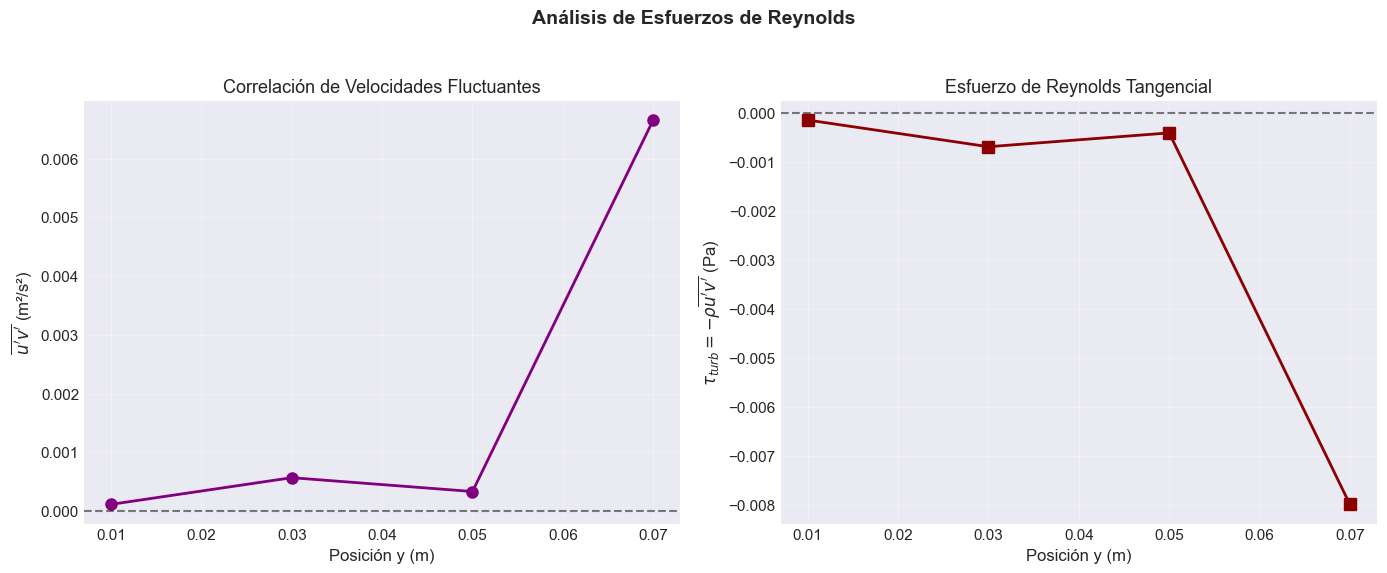


💡 Interpretación:
   - Correlación promedio $\overline{u'v'}$: 0.001919 m²/s²
   - Esfuerzo turbulento promedio $\tau_{turb}$: -0.002303 Pa
   - Coeficiente de correlación promedio $R_{uv}$: 0.118
   ⚠️ $\overline{u'v'}$ > 0: Transporte turbulento de momento alejándose de la pared (menos común).


In [20]:
print("💨 Iniciando Análisis de Esfuerzos de Reynolds...")

# Calcular correlación u'v' para cada posición
reynolds_stress_data = []
rho = 1.2  # kg/m³ (densidad aproximada del aire a 20°C, ajusta si es necesario)
print(f"   Usando densidad del aire ρ ≈ {rho} kg/m³")

for folder_path in folders: # folder_path ya es la ruta completa a la carpeta
    folder_name = folder_path.name
    print(f"\n   Procesando: {folder_name}")

    txt_files = sorted(list(folder_path.glob('*.txt')))

    if not txt_files:
        print(f"      No se encontraron archivos .txt. Omitiendo.")
        continue

    # Leer todos los archivos de la posición
    all_U = []
    all_V = []

    for file in txt_files:
        try:
            data = pd.read_csv(file, sep=r'\s+', header=None,
                              names=['idx', 'Doppler_Freq', 'SNR', 'U', 'V'])
            if not data.empty:
                all_U.extend(data['U'].values)
                all_V.extend(data['V'].values)
        except Exception as e:
            print(f"      Error leyendo {file.name}: {e}")
            continue

    if not all_U or not all_V:
        print("      No se pudieron leer datos válidos de U y V. Omitiendo.")
        continue

    U_array = np.array(all_U)
    V_array = np.array(all_V)

    try:
        U_clean, mask_U = remove_outliers_iqr(U_array)
        V_clean, mask_V = remove_outliers_iqr(V_array)
    except NameError:
        print("      Error: La función 'remove_outliers_iqr' no está definida.")
        print("             Asegúrate de ejecutar la celda [7] primero.")
        break
    except Exception as e:
        print(f"      Error durante la eliminación de outliers: {e}")
        continue

    combined_mask = mask_U & mask_V
    if len(U_array) != len(V_array):
         print(f"      Advertencia: Longitudes originales de U ({len(U_array)}) y V ({len(V_array)}) difieren. Usando pares coincidentes.")
         min_len_orig = min(len(U_array), len(V_array))
         combined_mask = mask_U[:min_len_orig] & mask_V[:min_len_orig]
         U_for_corr = U_array[:min_len_orig][combined_mask]
         V_for_corr = V_array[:min_len_orig][combined_mask]
    else:
        U_for_corr = U_array[combined_mask]
        V_for_corr = V_array[combined_mask]


    if len(U_for_corr) < 2:
        print("      Datos insuficientes después de limpiar outliers para calcular correlación. Omitiendo.")
        uv_correlation = np.nan
        reynolds_stress = np.nan
        correlation_coef = np.nan
        u_std_clean = np.nan
        v_std_clean = np.nan
    else:
        # Calcular fluctuaciones (u' = U - U_mean, v' = V - V_mean)
        U_mean_clean = np.mean(U_for_corr)
        V_mean_clean = np.mean(V_for_corr)
        u_prime = U_for_corr - U_mean_clean
        v_prime = V_for_corr - V_mean_clean

        # Correlación u'v'
        uv_correlation = np.mean(u_prime * v_prime)

        # Esfuerzo de Reynolds
        reynolds_stress = -rho * uv_correlation

        # Coeficiente de correlación R_uv = u'v' / (std(u) * std(v))
        u_std_clean = np.std(u_prime) # std de las fluctuaciones es std de los datos limpios
        v_std_clean = np.std(v_prime)
        if u_std_clean > 1e-9 and v_std_clean > 1e-9: # Evitar división por cero
             correlation_coef = uv_correlation / (u_std_clean * v_std_clean)
        else:
             correlation_coef = np.nan


    # --- CORRECCIÓN: Obtener y (m) desde df_profile ---
    try:
        y_pos_m = df_profile.loc[df_profile['Posición'] == folder_name, 'y (mm)'].iloc[0] / 1000.0
    except (IndexError, KeyError):
        print(f"      Advertencia: No se encontró la posición y para {folder_name} en df_profile.")
        y_pos_m = np.nan # O asignar un valor por defecto si lo conoces

    reynolds_stress_data.append({
        'Posición': folder_name,
        'y (m)': y_pos_m,
        'u\'v\' (m²/s²)': uv_correlation,
        'τ_turb (Pa)': reynolds_stress,
        'Coef_Corr': correlation_coef, # Nombre más corto
        'u_std (m/s)': u_std_clean, # Guardar std para referencia
        'v_std (m/s)': v_std_clean
    })

reynolds_stress_df = pd.DataFrame(reynolds_stress_data)

print("\nEsfuerzos de Reynolds por posición:\n")
print(reynolds_stress_df.to_string(index=False,
                                   float_format=lambda x: f"{x:.4f}" if abs(x) < 0.1 else f"{x:.3f}" if abs(x) < 10 else f"{x:.2f}"))

reynolds_stress_df_valid = reynolds_stress_df.dropna(subset=['u\'v\' (m²/s²)', 'τ_turb (Pa)', 'y (m)'])
if not reynolds_stress_df_valid.empty:
    fig_rs, (ax1_rs, ax2_rs) = plt.subplots(1, 2, figsize=(14, 6))
    fig_rs.suptitle('Análisis de Esfuerzos de Reynolds', fontsize=14, fontweight='bold')

    reynolds_stress_df_valid = reynolds_stress_df_valid.sort_values(by='y (m)')

    # Correlación u'v'
    ax1_rs.plot(reynolds_stress_df_valid['y (m)'], reynolds_stress_df_valid['u\'v\' (m²/s²)'],
             'o-', linewidth=2, markersize=8, color='purple')
    ax1_rs.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1_rs.set_xlabel('Posición y (m)', fontsize=12)
    ax1_rs.set_ylabel('$\overline{u\'v\'}$ (m²/s²)', fontsize=12)
    ax1_rs.set_title('Correlación de Velocidades Fluctuantes', fontsize=13)
    ax1_rs.grid(True, alpha=0.3)

    # Esfuerzo turbulento τ_turb
    ax2_rs.plot(reynolds_stress_df_valid['y (m)'], reynolds_stress_df_valid['τ_turb (Pa)'],
             's-', linewidth=2, markersize=8, color='darkred')
    ax2_rs.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2_rs.set_xlabel('Posición y (m)', fontsize=12)
    ax2_rs.set_ylabel('$\\tau_{turb} = -\\rho \\overline{u\'v\'}$ (Pa)', fontsize=12)
    ax2_rs.set_title('Esfuerzo de Reynolds Tangencial', fontsize=13)
    ax2_rs.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(IMAGES_DIR, 'esfuerzos_de_reynolds.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(IMAGES_DIR, 'esfuerzos_de_reynolds.svg'), bbox_inches='tight')
    plt.show()

    print(f"\n💡 Interpretación:")
    uv_mean = reynolds_stress_df_valid['u\'v\' (m²/s²)'].mean()
    tau_mean = reynolds_stress_df_valid['τ_turb (Pa)'].mean()
    corr_mean = reynolds_stress_df_valid['Coef_Corr'].mean()

    if not np.isnan(uv_mean):
        print(f"   - Correlación promedio $\overline{{u'v'}}$: {uv_mean:.6f} m²/s²")
        print(f"   - Esfuerzo turbulento promedio $\\tau_{{turb}}$: {tau_mean:.6f} Pa")
        print(f"   - Coeficiente de correlación promedio $R_{{uv}}$: {corr_mean:.3f}")

        if uv_mean < -1e-6: # Umbral pequeño para considerar negativo
            print(f"   ✅ $\overline{{u'v'}}$ < 0: Transporte turbulento de momento hacia la pared (esperado en capa límite).")
        elif uv_mean > 1e-6: # Umbral pequeño para considerar positivo
            print(f"   ⚠️ $\overline{{u'v'}}$ > 0: Transporte turbulento de momento alejándose de la pared (menos común).")
        else:
            print(f"   ⚪ $\overline{{u'v'}}$ ≈ 0: Correlación muy baja o nula entre u' y v'.")
    else:
        print("   - No se pudieron calcular valores medios válidos para la interpretación.")

else:
    print("\n   No hay suficientes datos válidos para graficar los esfuerzos de Reynolds.")